# Some fun with CIFAR-10
## Environment setup

In [1]:
# This is specific to my installation
import os
os.environ["PATH"] = os.pathsep.join(
    [p for p in os.environ["PATH"].split(os.pathsep) if "NVIDIA" not in p]
    + [
        r"C:\Program Files\NVIDIA\CUDNN\v8.1\bin",
        r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\bin",
    ]
)

# Required libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Utility function to generate a TensorBoard callback
def tbcb(s):
    return tf.keras.callbacks.TensorBoard(
        log_dir="./logs/" + s + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    )

## Warming up. Meet our data!

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_test, y_train = y_test[:, 0], y_train[:, 0]
labelnames = "airplane automobile bird cat deer dog frog horse ship truck".split()

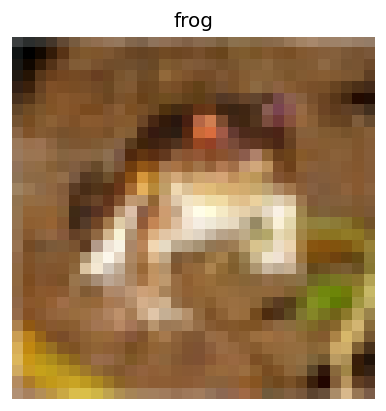

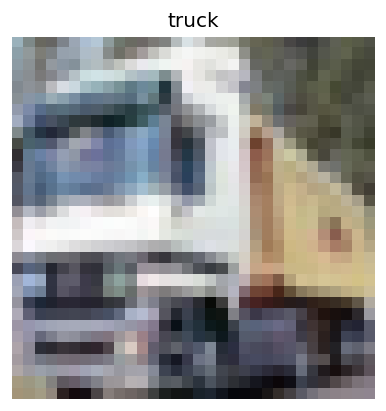

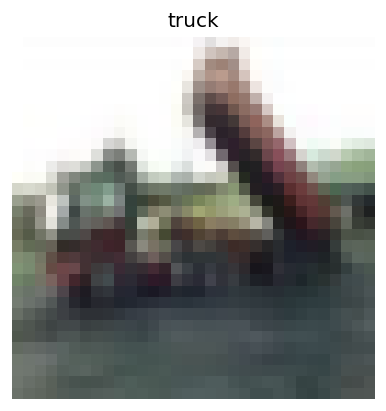

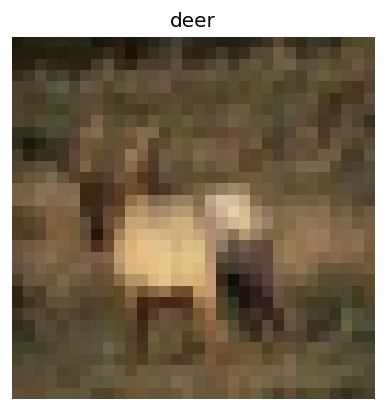

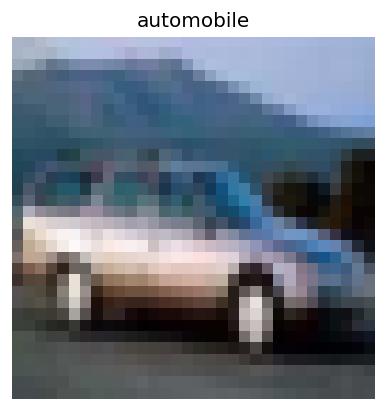

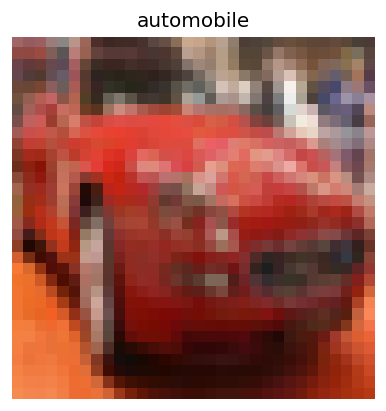

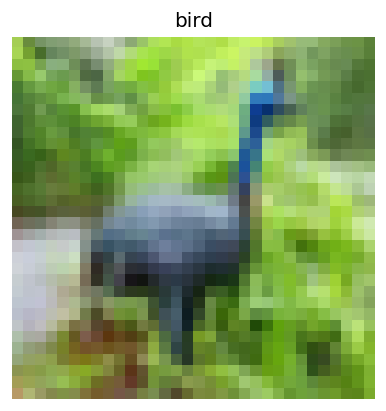

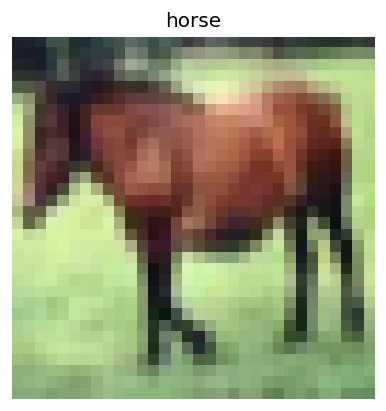

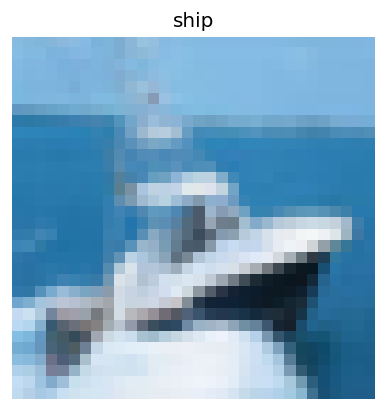

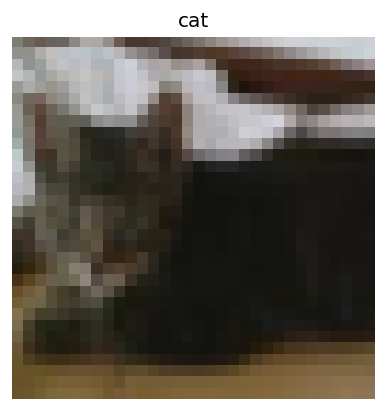

In [9]:
def showim(im, l=None, ax=None):
    """Displays the image im
    in axis ax (or a new figure if not given),
    and set the title to the name
    corresponding to label l (if given)"""
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(im)
    ax.axis("off")
    if l is not None:
        ax.set_title(labelnames[l])


# %% Let's visualize some of our training images
for i in range(10):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=120)
    showim(x_train[i, :, :, :], l=y_train[i], ax=ax)
    plt.show()

## Supervised problem: baseline
Build a baseline classification approach
Can you do better than random with three lines of code and **no library**?

Ground truth label:  cat
Estimated label:  deer


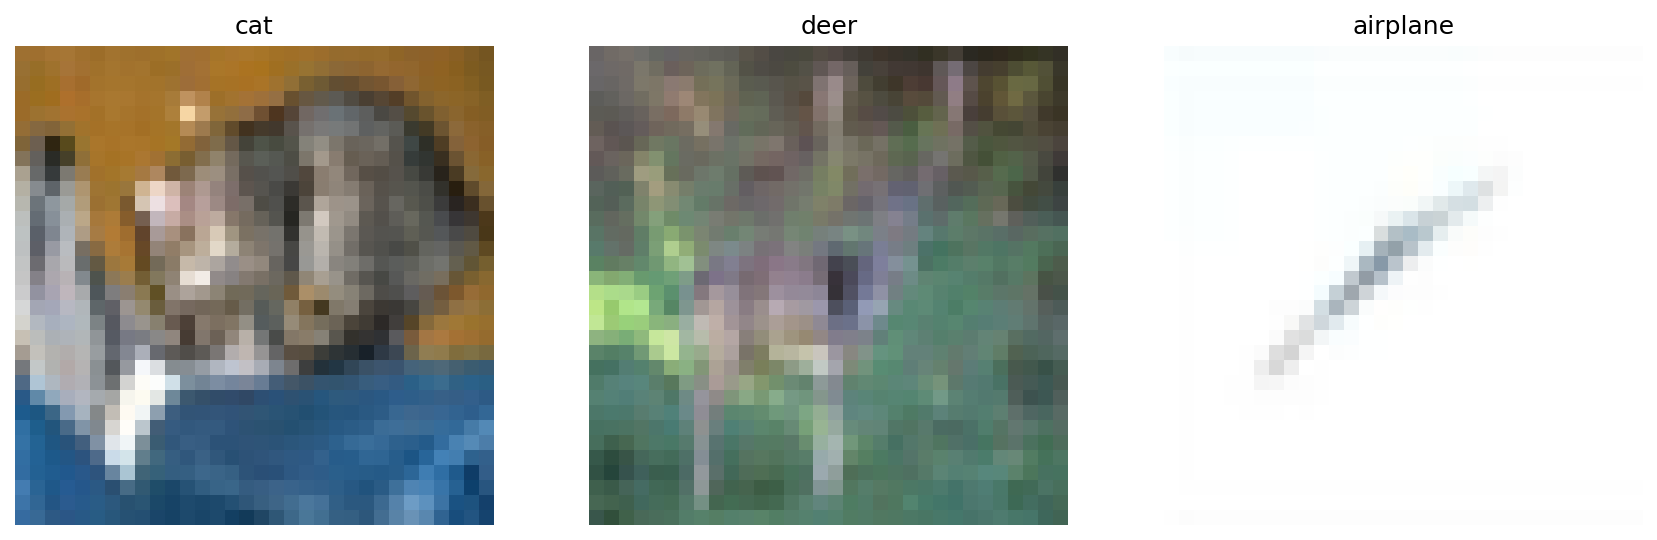

Ground truth label:  ship
Estimated label:  ship


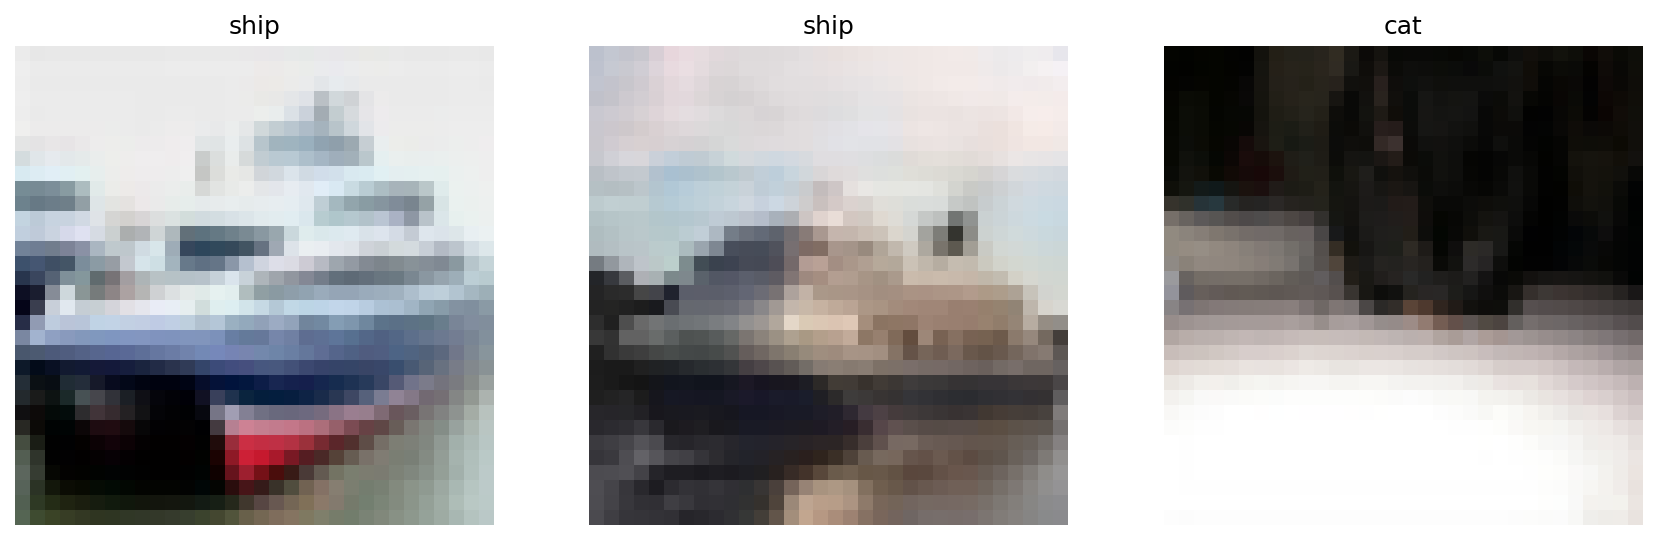

Ground truth label:  ship
Estimated label:  ship


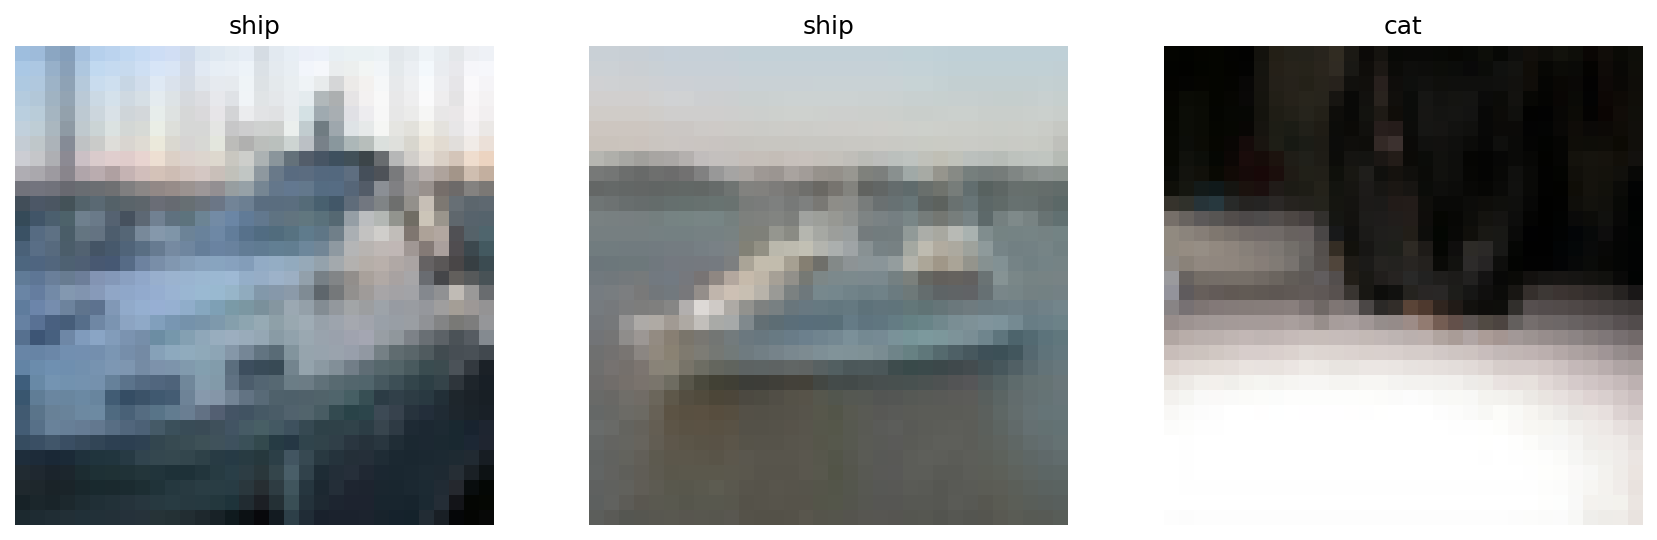

Ground truth label:  airplane
Estimated label:  airplane


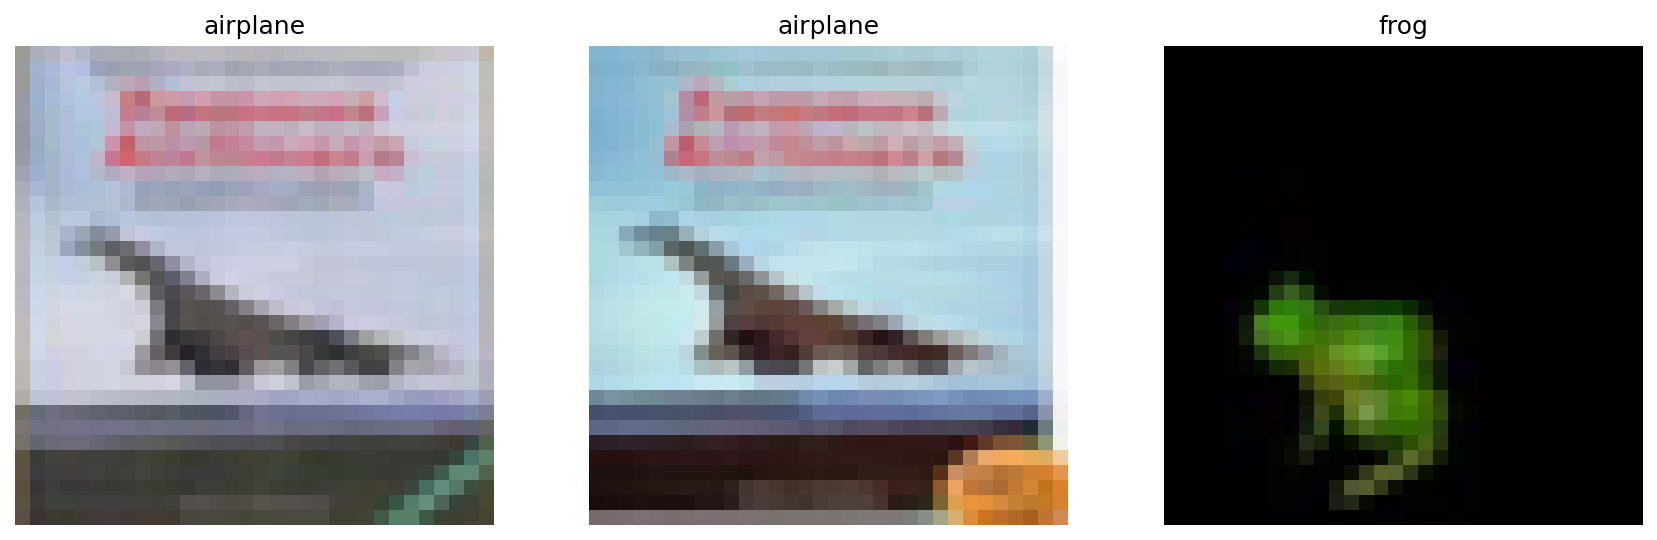

Ground truth label:  frog
Estimated label:  deer


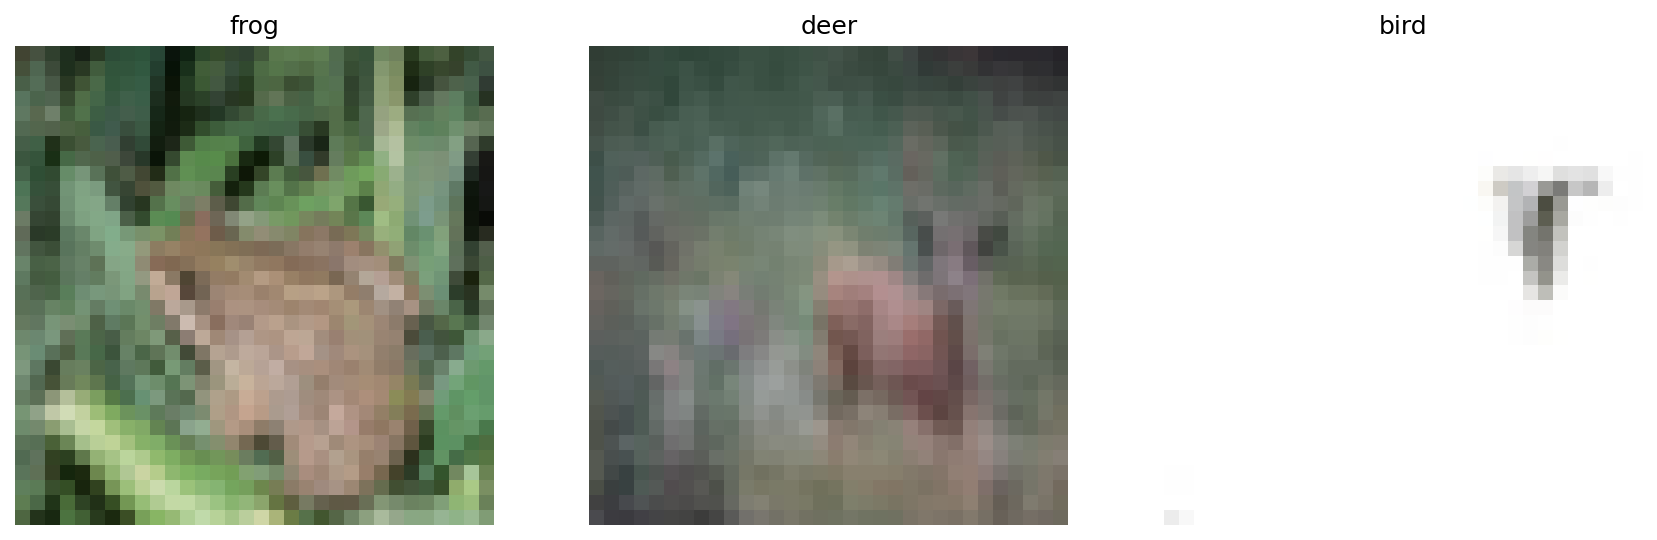

Ground truth label:  frog
Estimated label:  frog


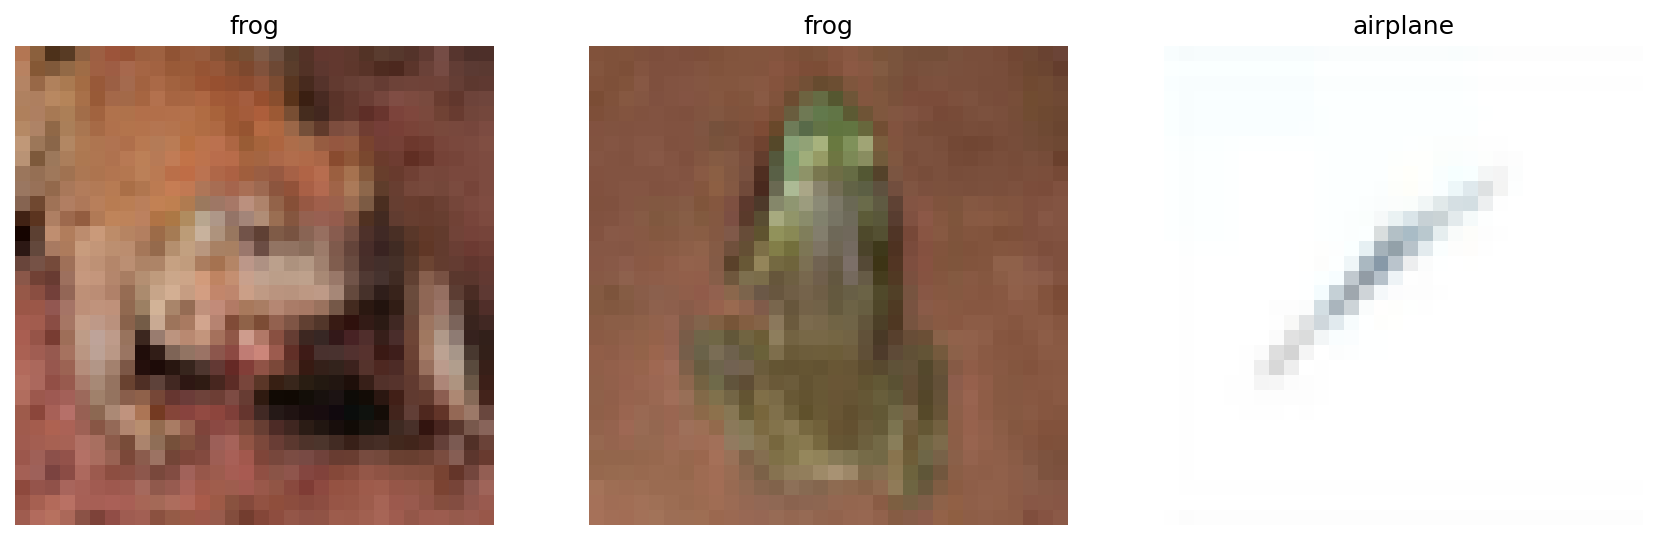

Ground truth label:  automobile
Estimated label:  deer


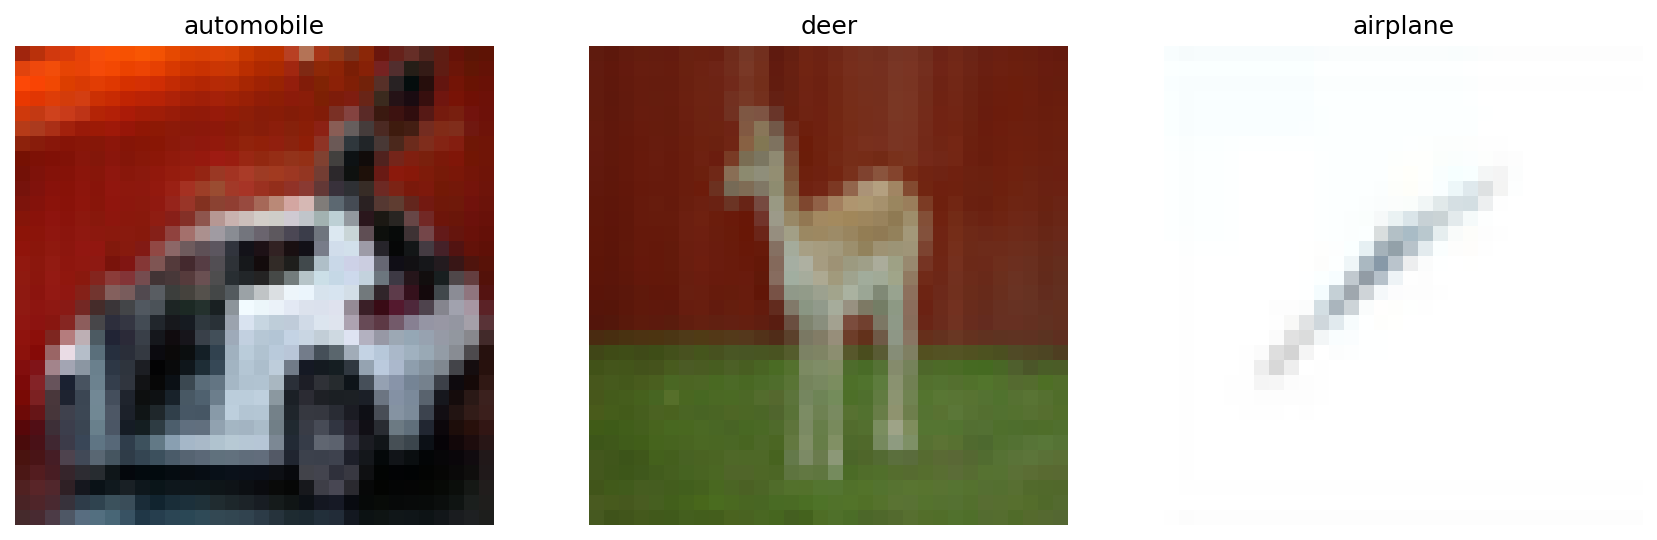

Ground truth label:  frog
Estimated label:  bird


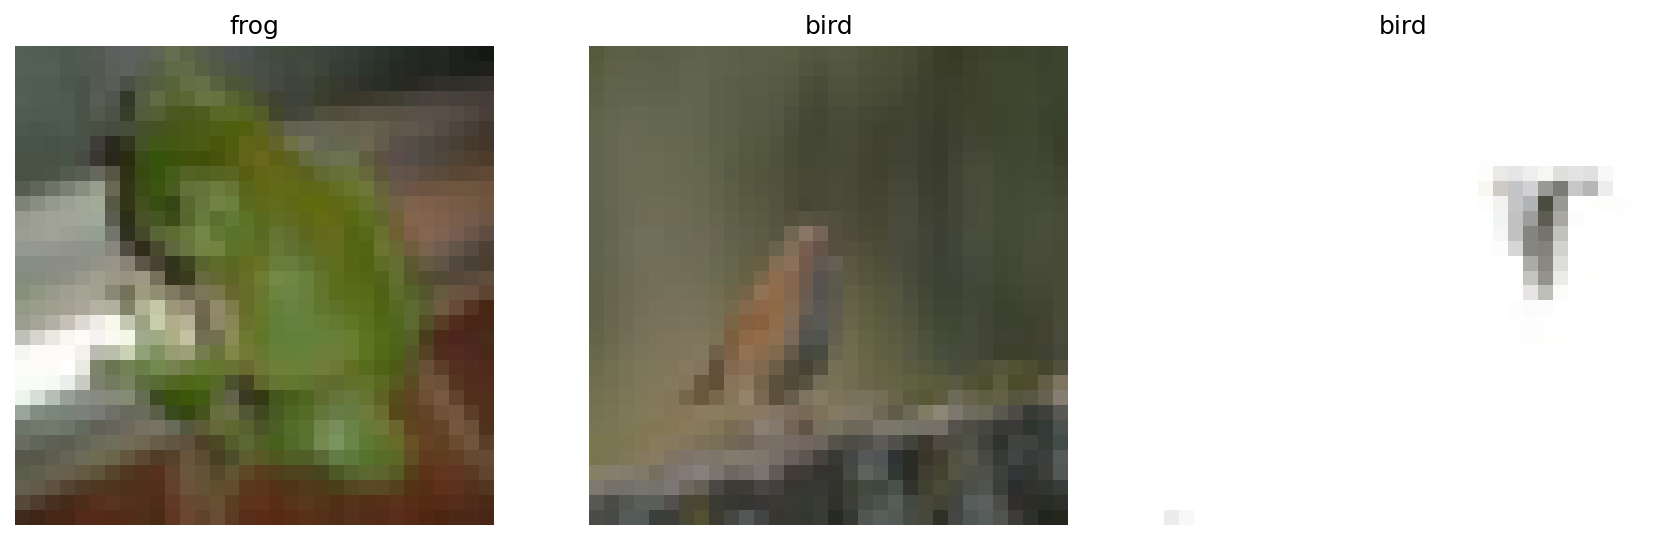

Ground truth label:  cat
Estimated label:  deer


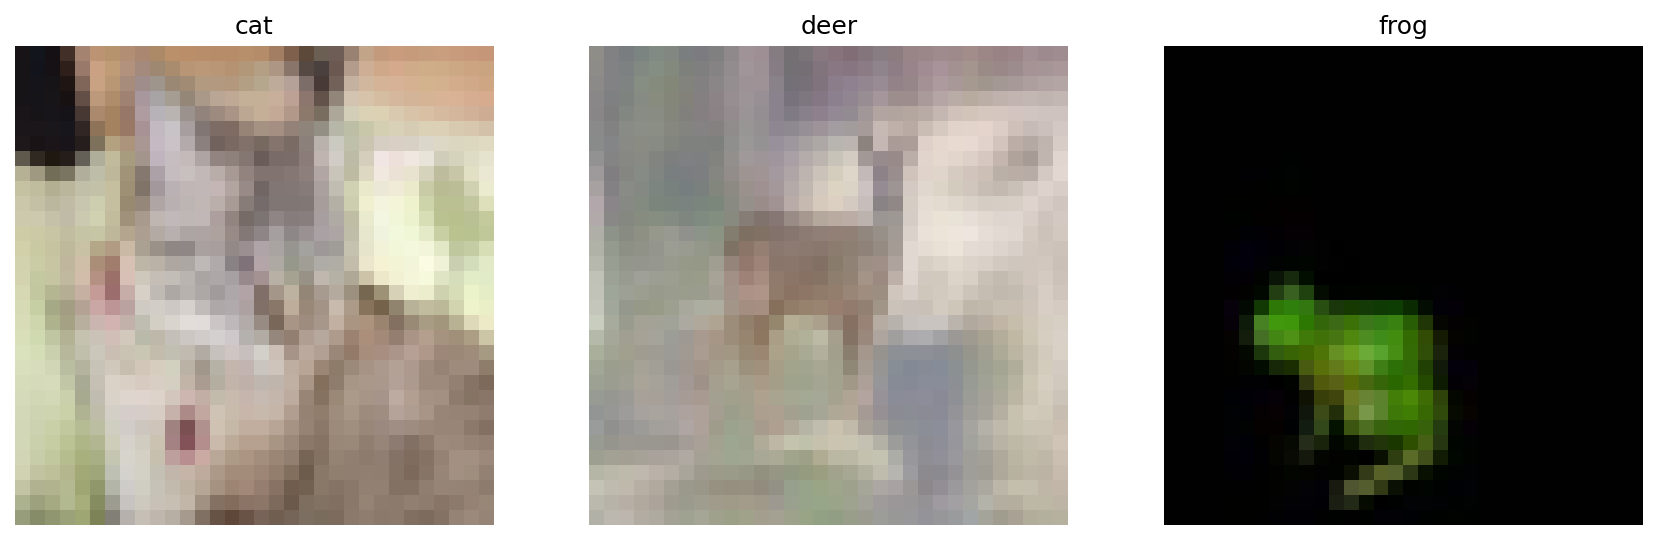

Ground truth label:  automobile
Estimated label:  ship


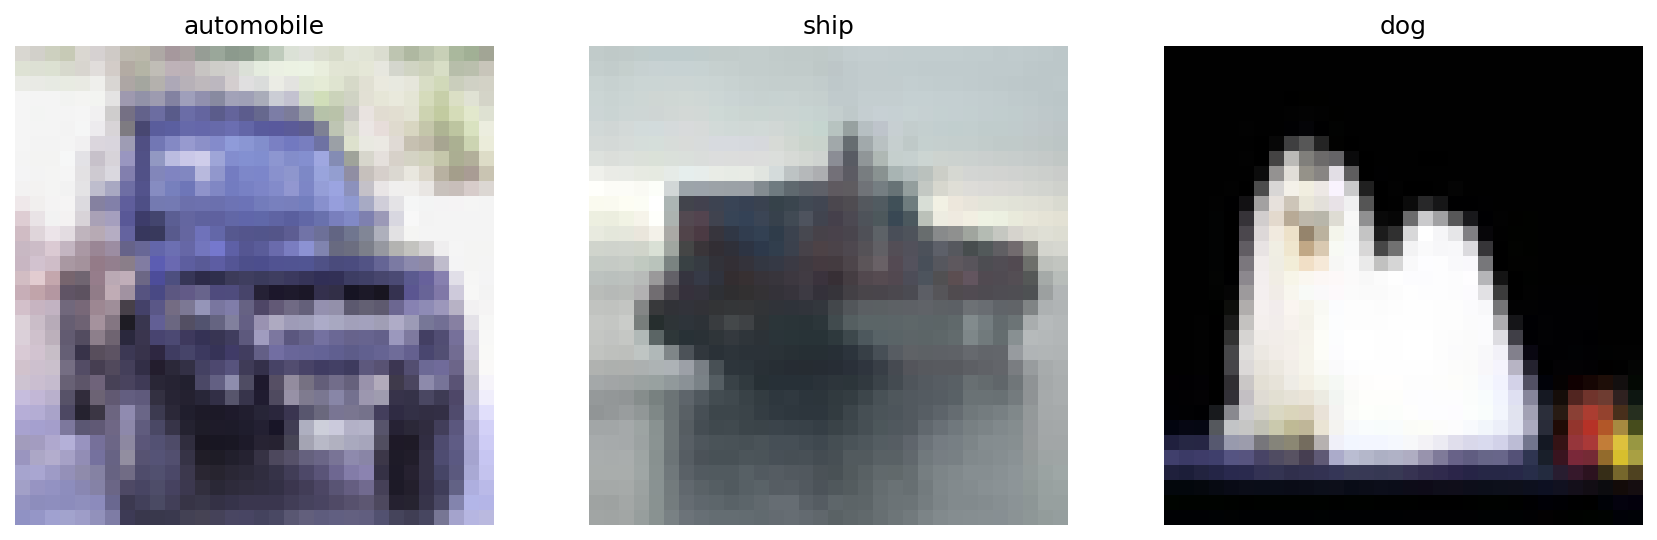

Ground truth label:  airplane
Estimated label:  ship


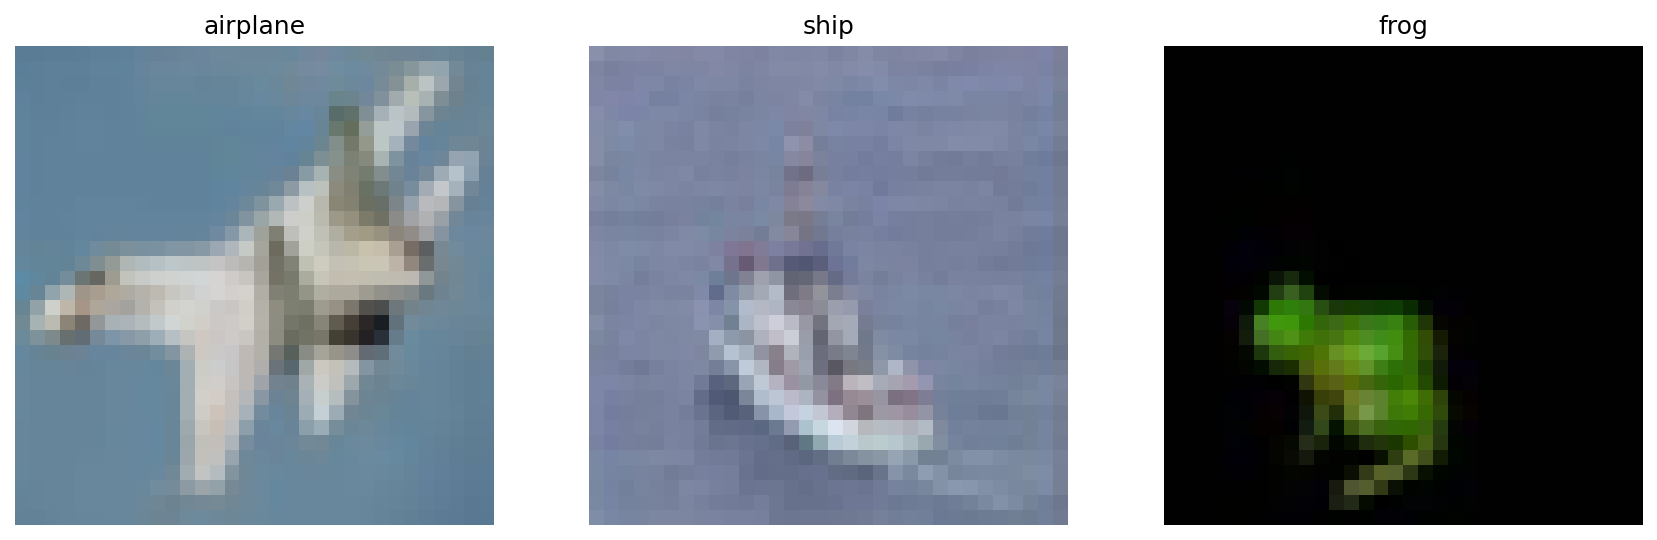

Ground truth label:  truck
Estimated label:  ship


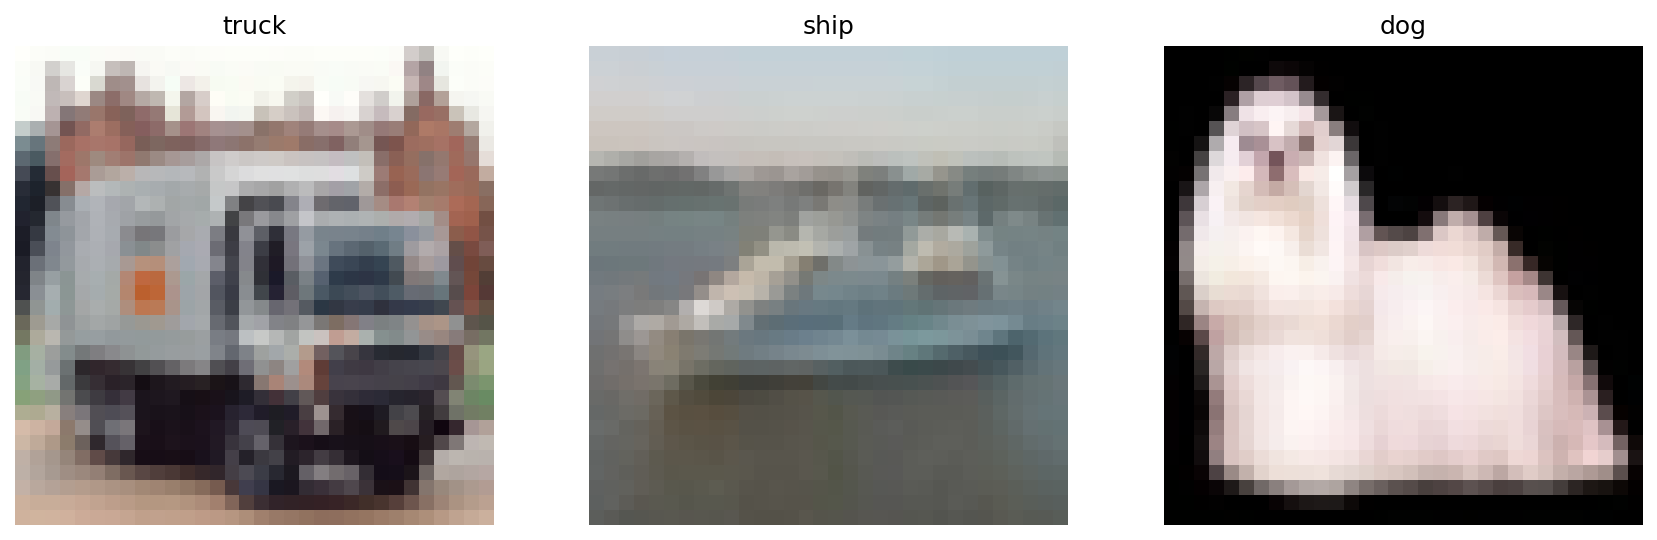

Ground truth label:  dog
Estimated label:  dog


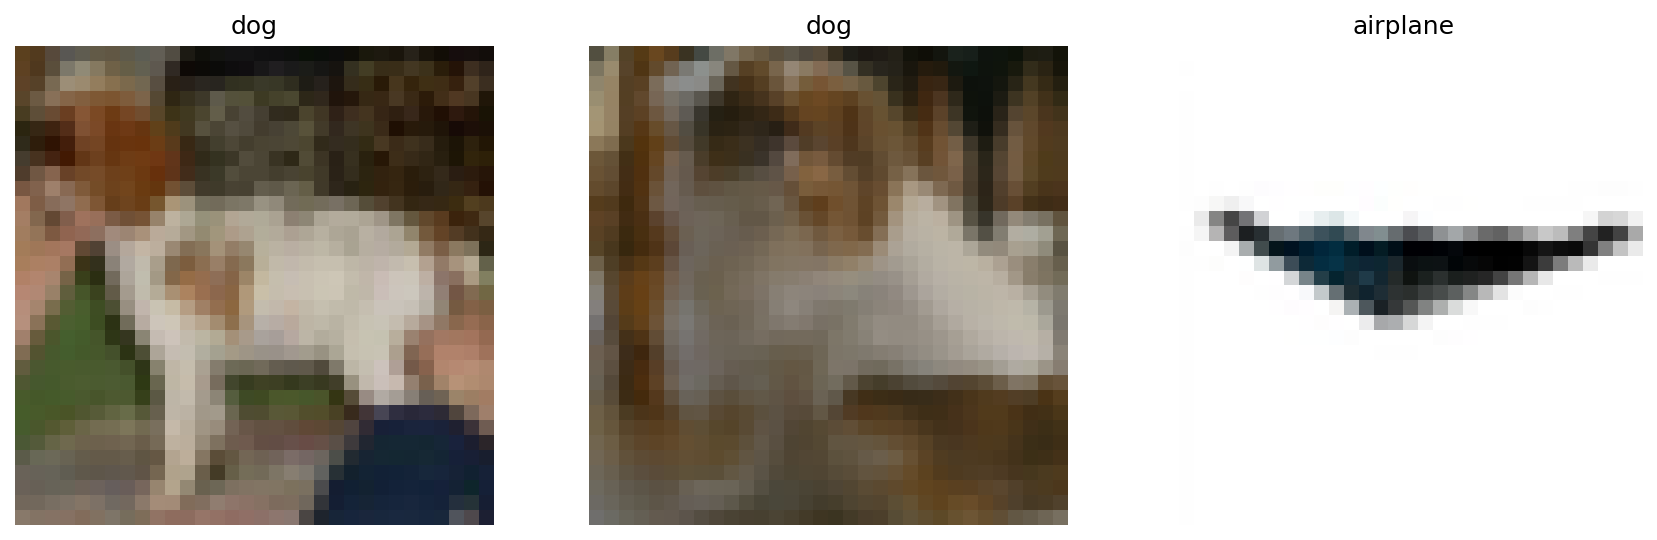

Ground truth label:  horse
Estimated label:  frog


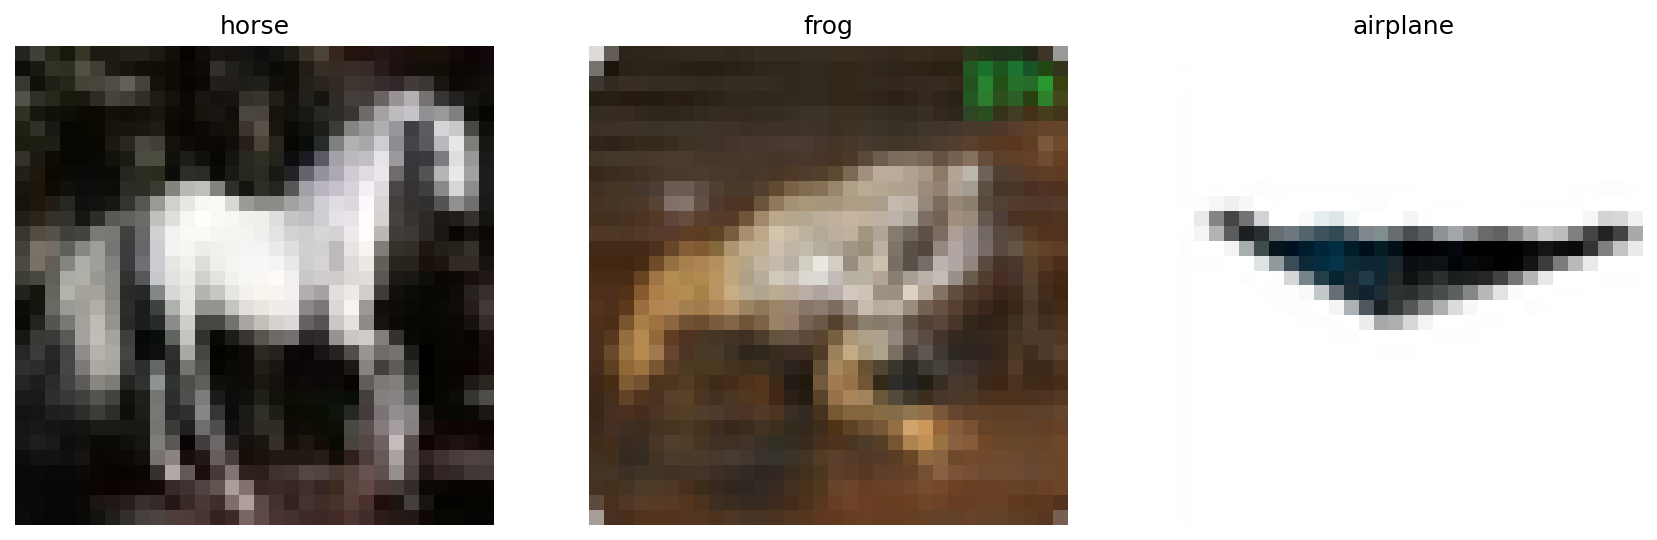

Ground truth label:  truck
Estimated label:  deer


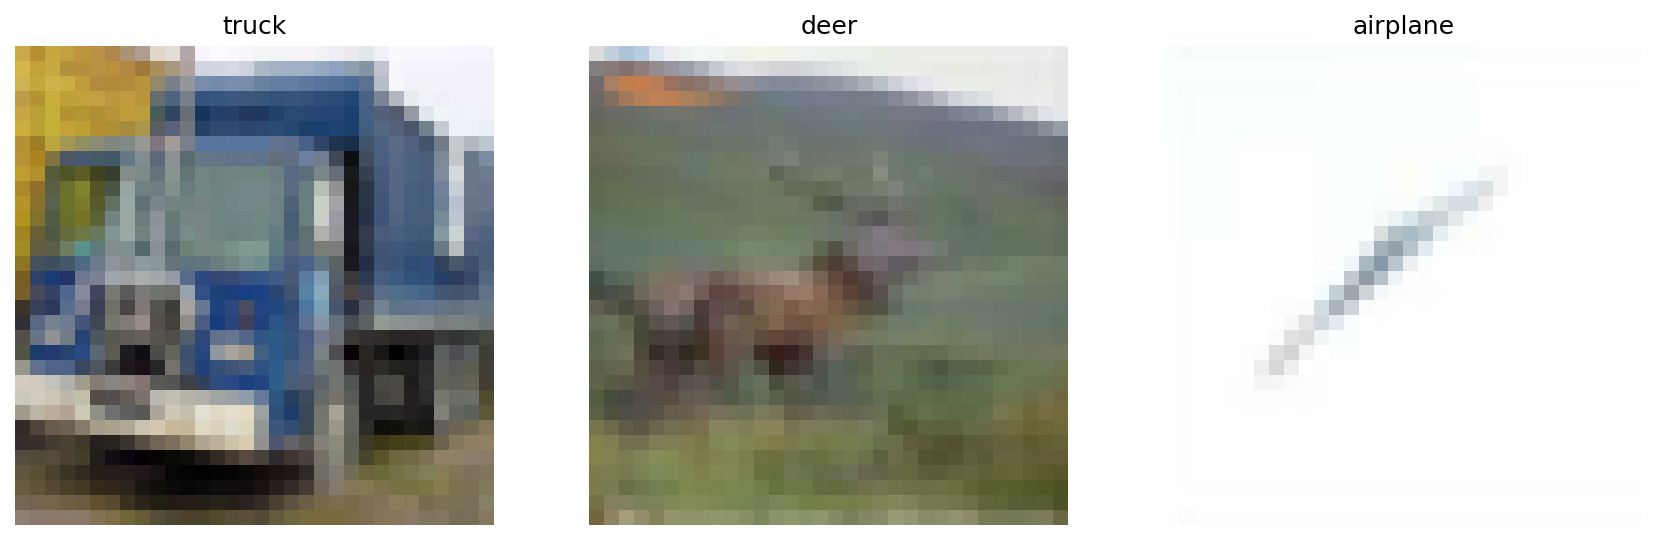

Ground truth label:  ship
Estimated label:  deer


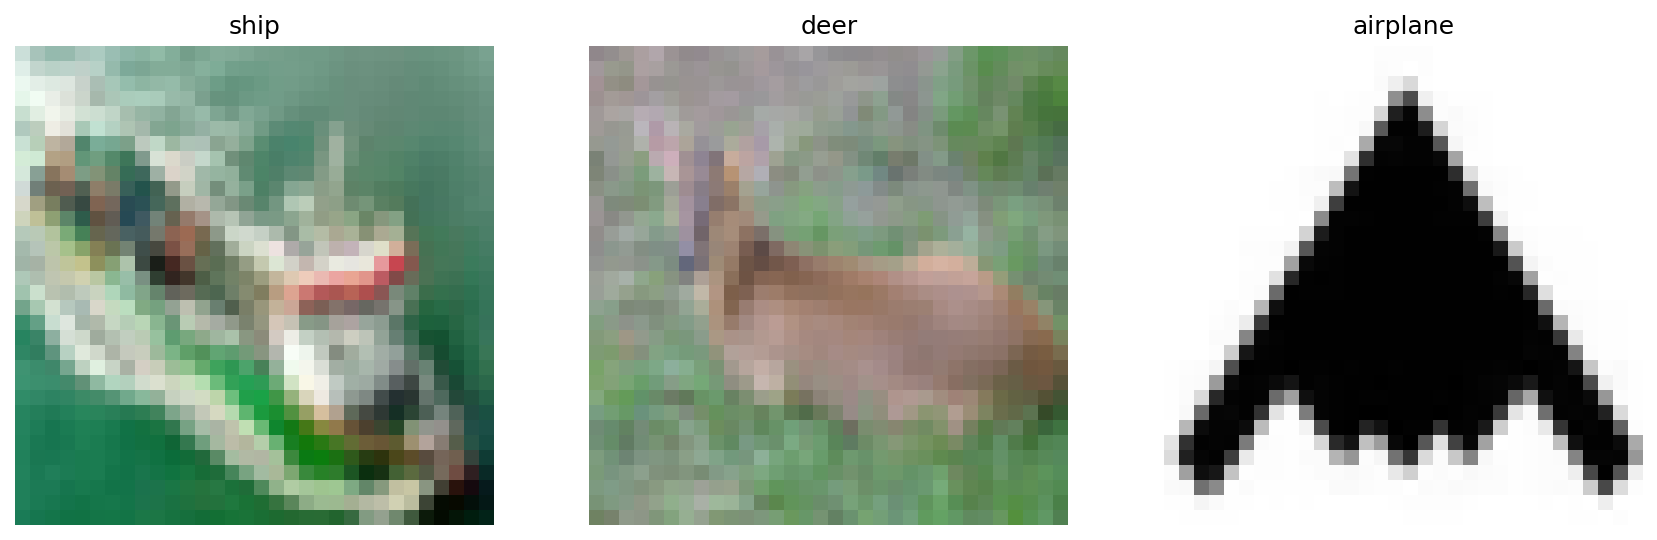

Ground truth label:  dog
Estimated label:  cat


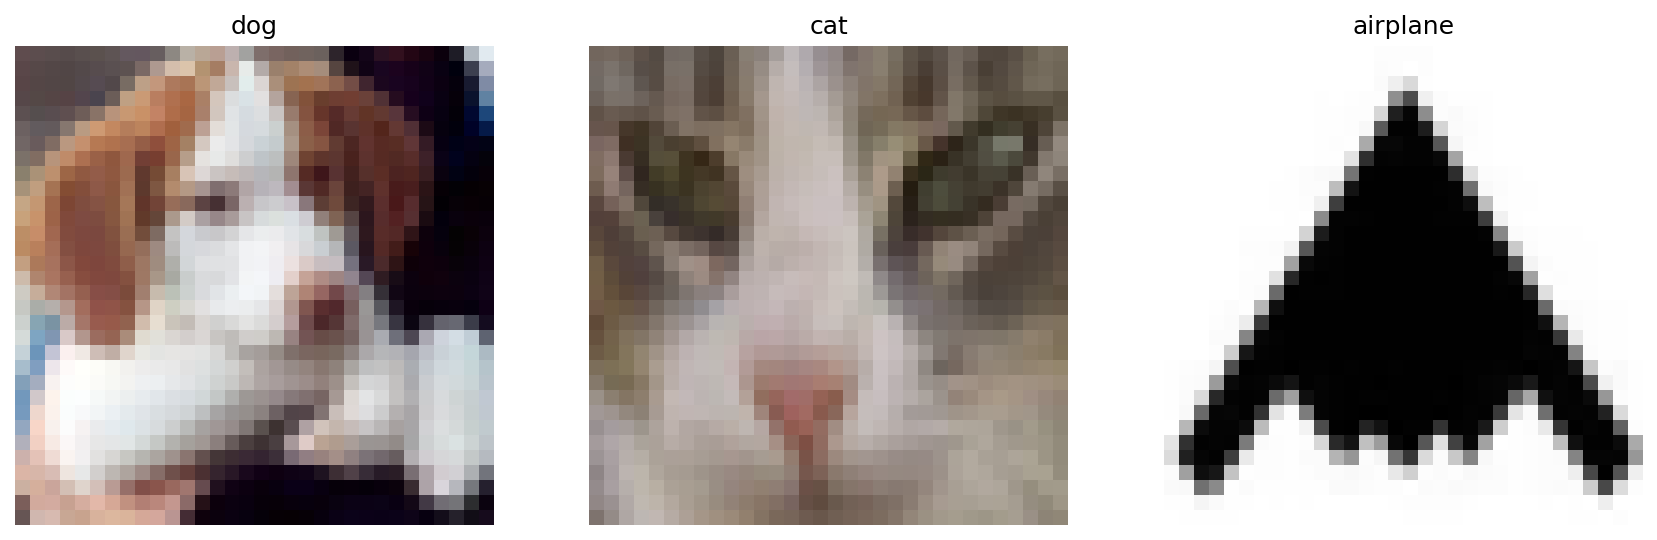

Ground truth label:  horse
Estimated label:  cat


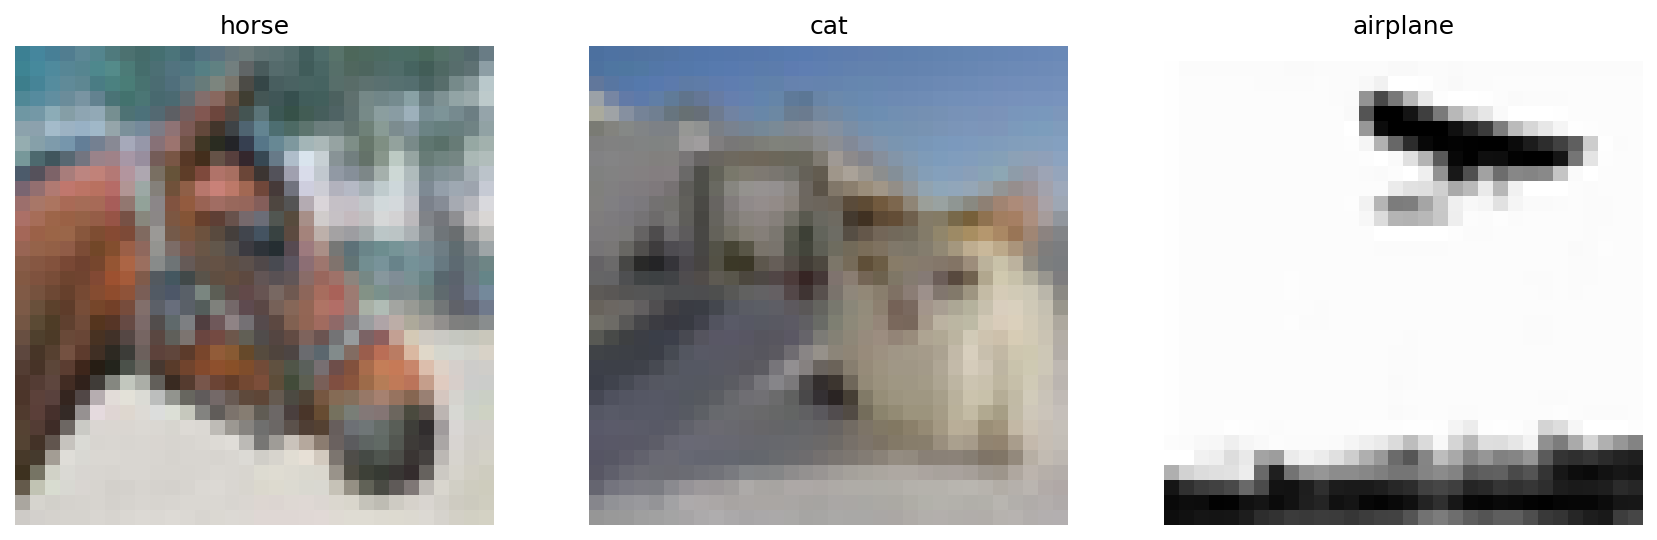

Ground truth label:  ship
Estimated label:  automobile


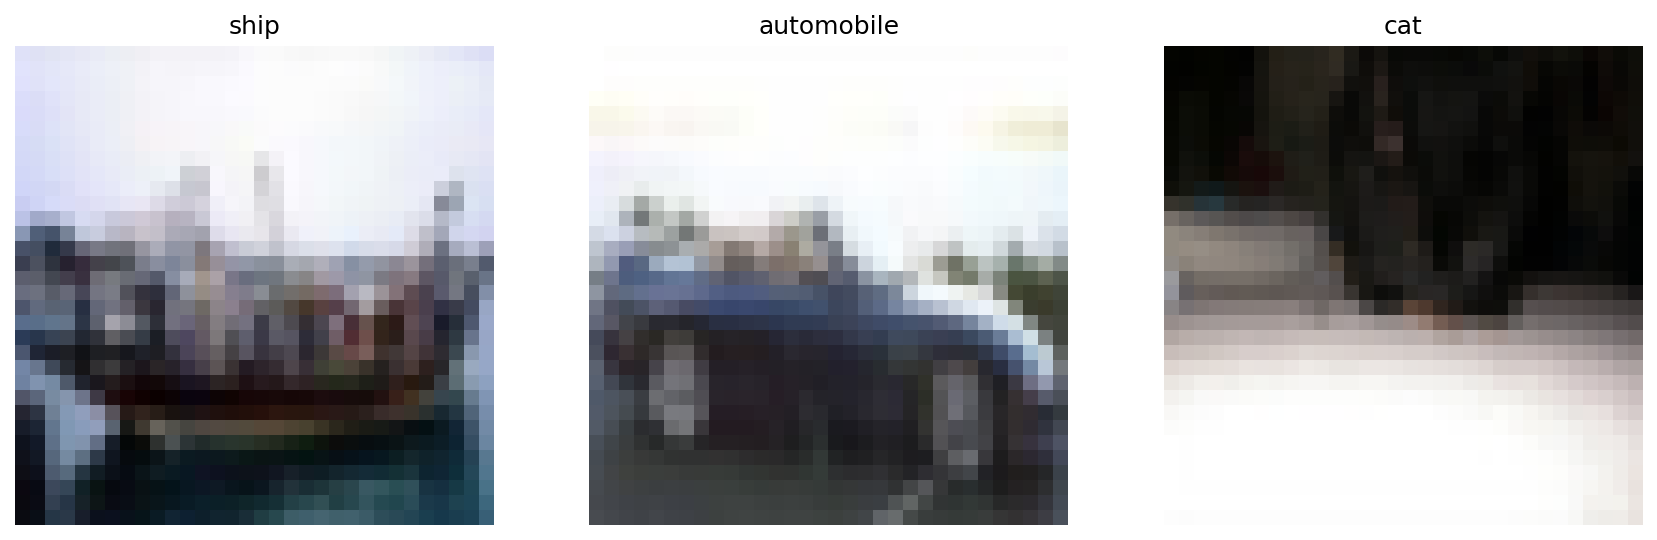

Ground truth label:  frog
Estimated label:  frog


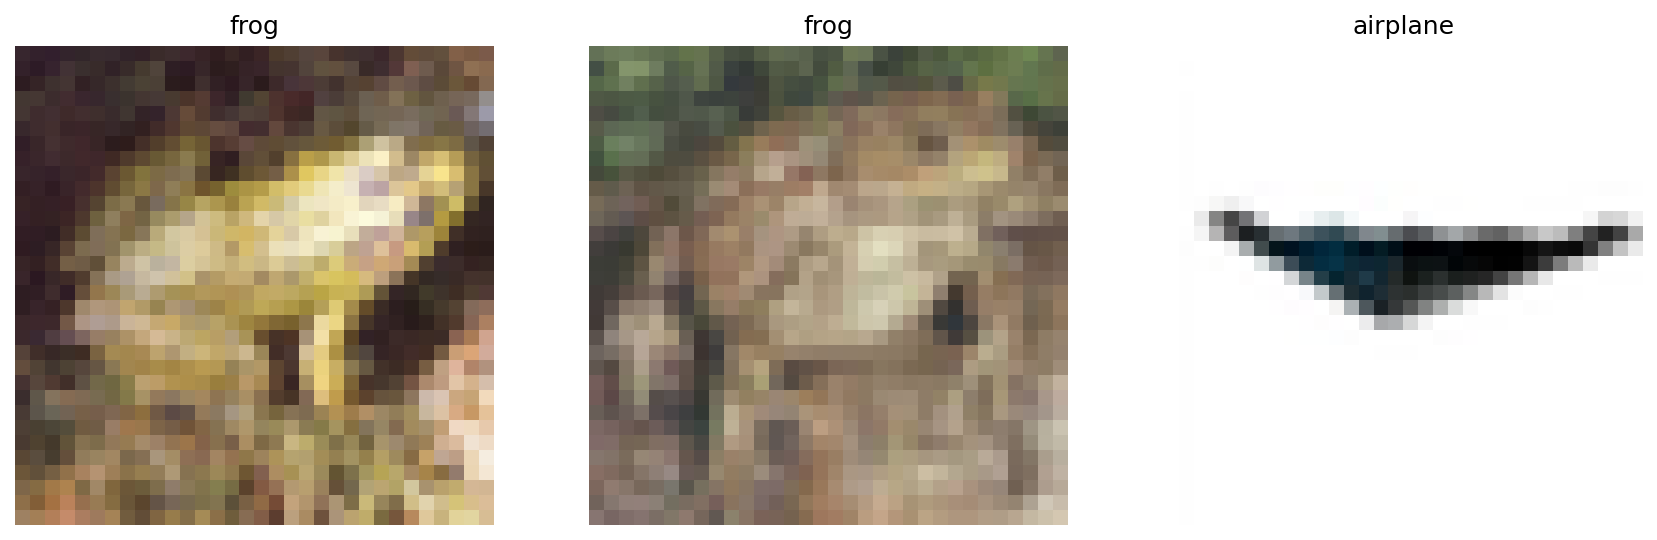

Ground truth label:  horse
Estimated label:  ship


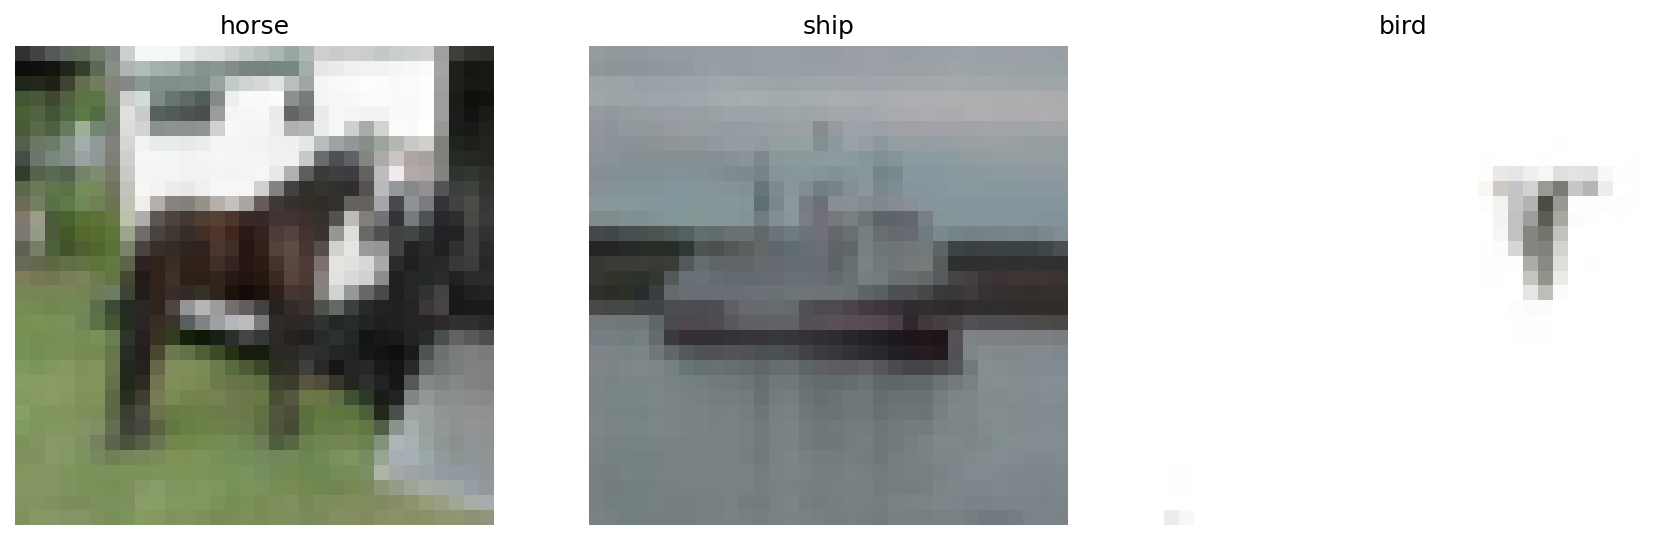

Ground truth label:  airplane
Estimated label:  airplane


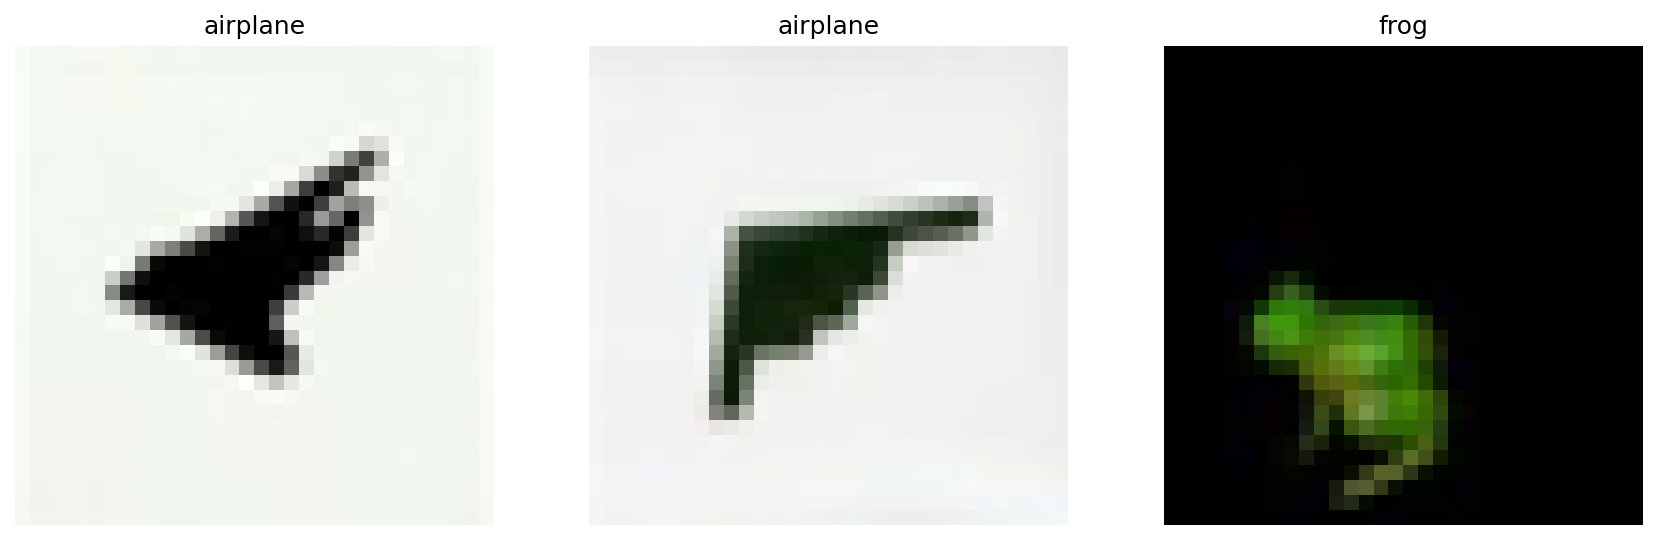

Ground truth label:  deer
Estimated label:  airplane


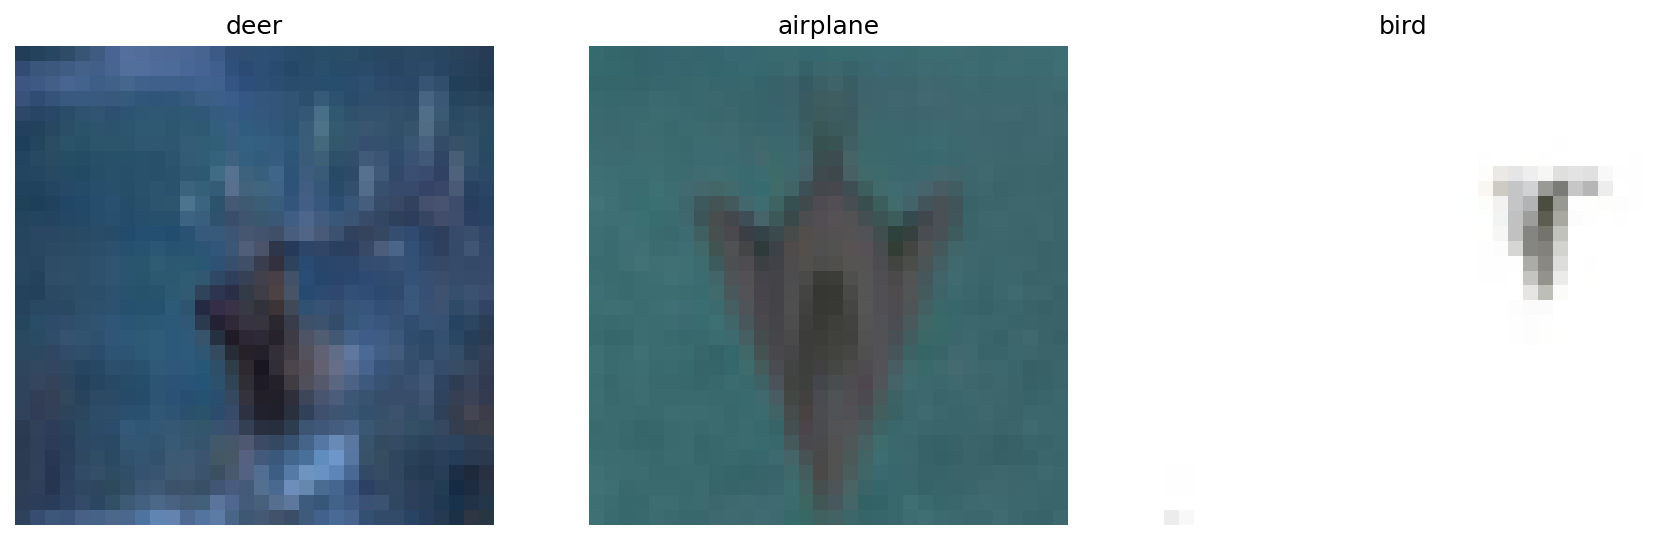

Ground truth label:  truck
Estimated label:  horse


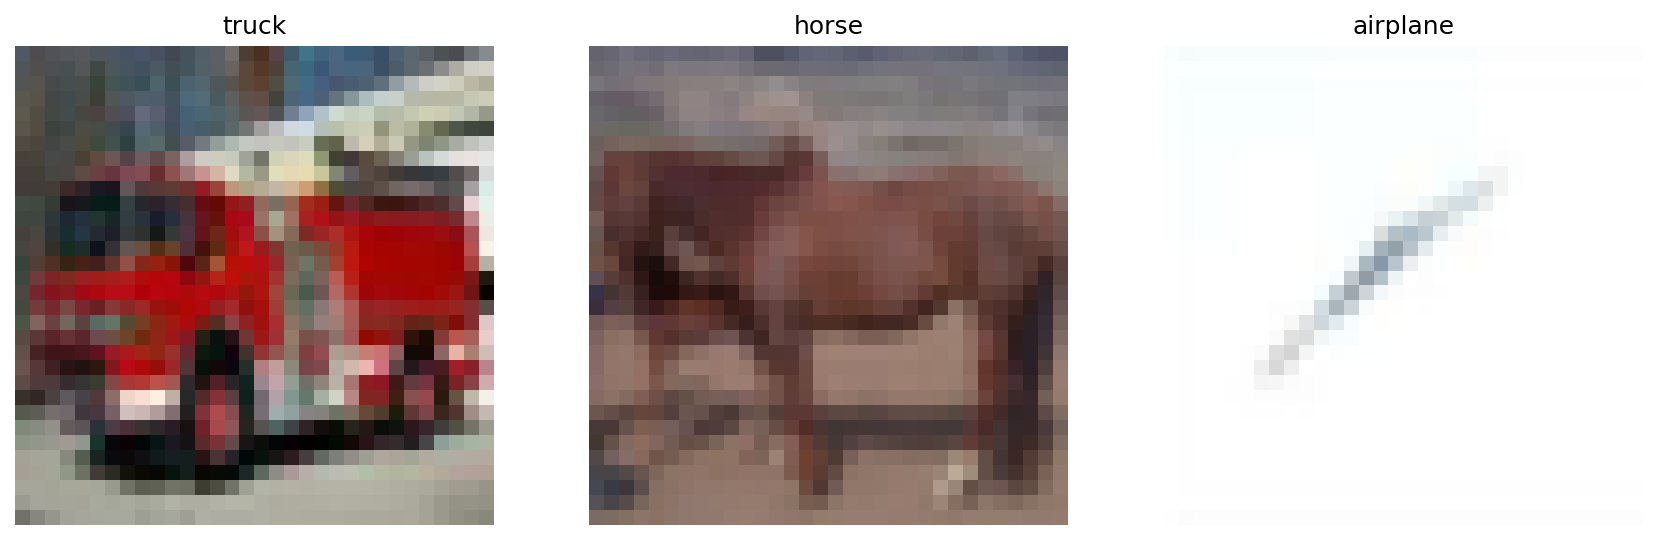

Ground truth label:  dog
Estimated label:  deer


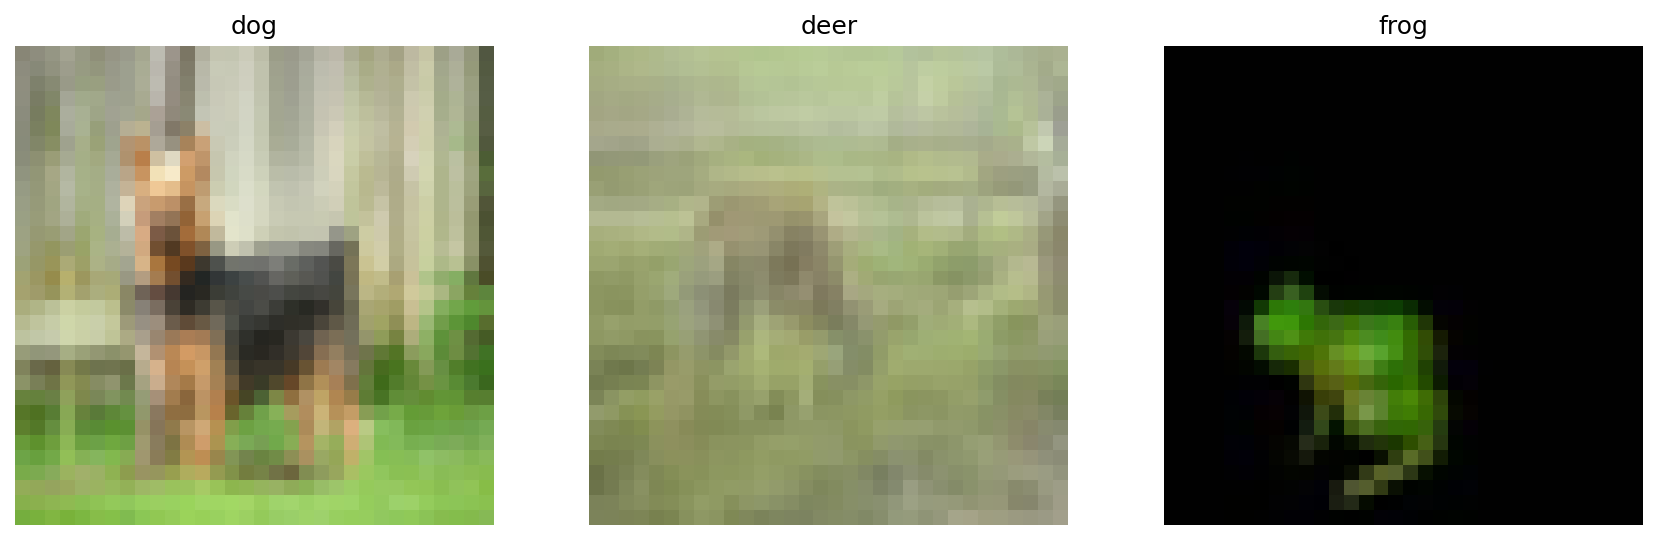

Ground truth label:  bird
Estimated label:  deer


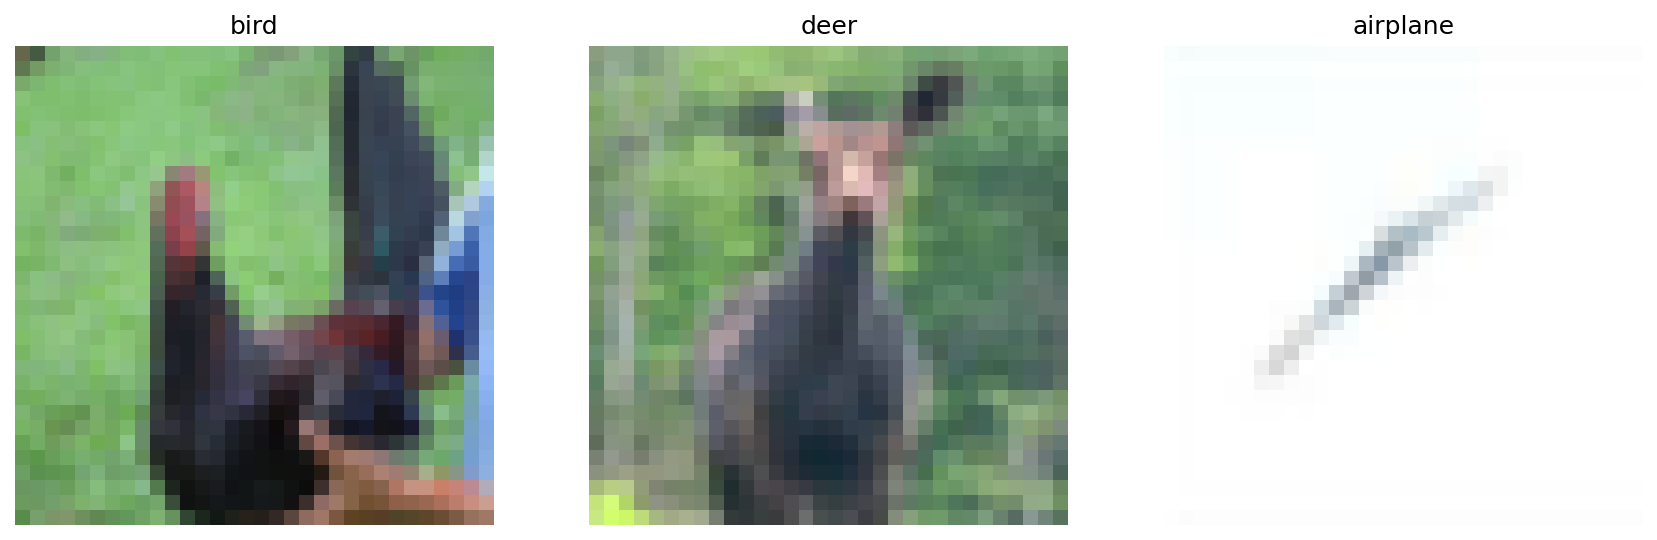

Ground truth label:  deer
Estimated label:  frog


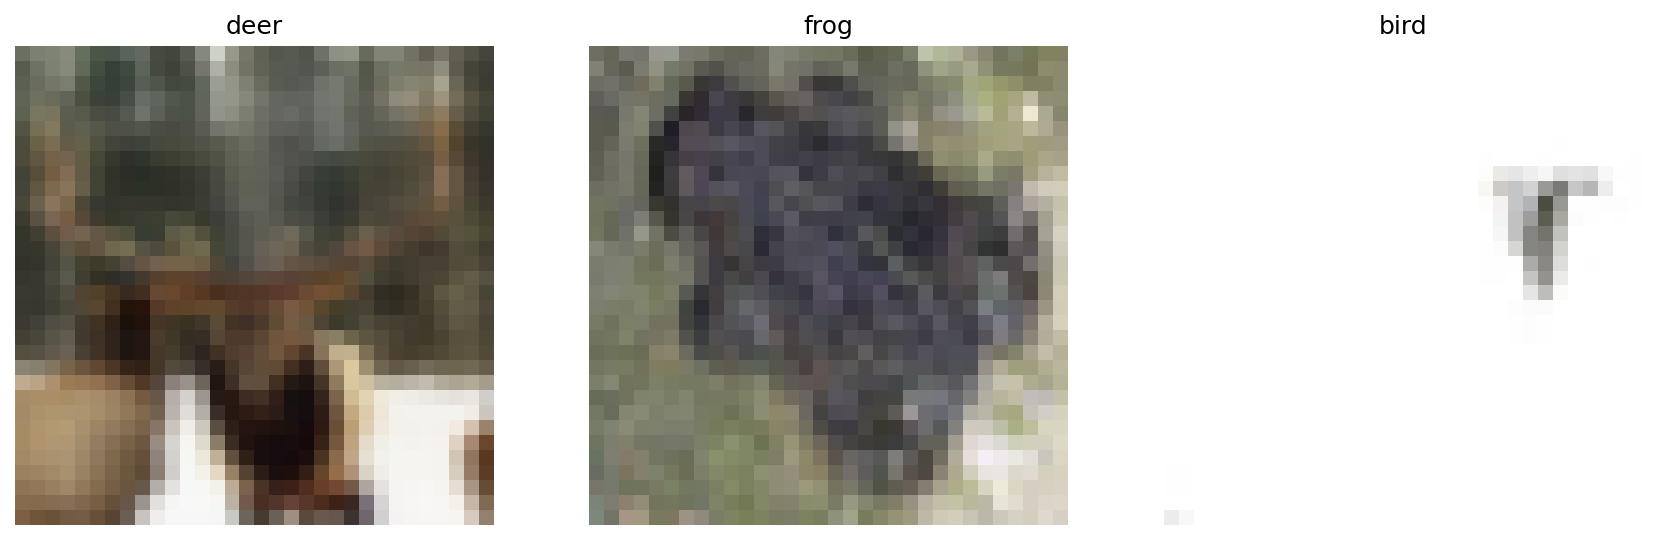

Ground truth label:  airplane
Estimated label:  truck


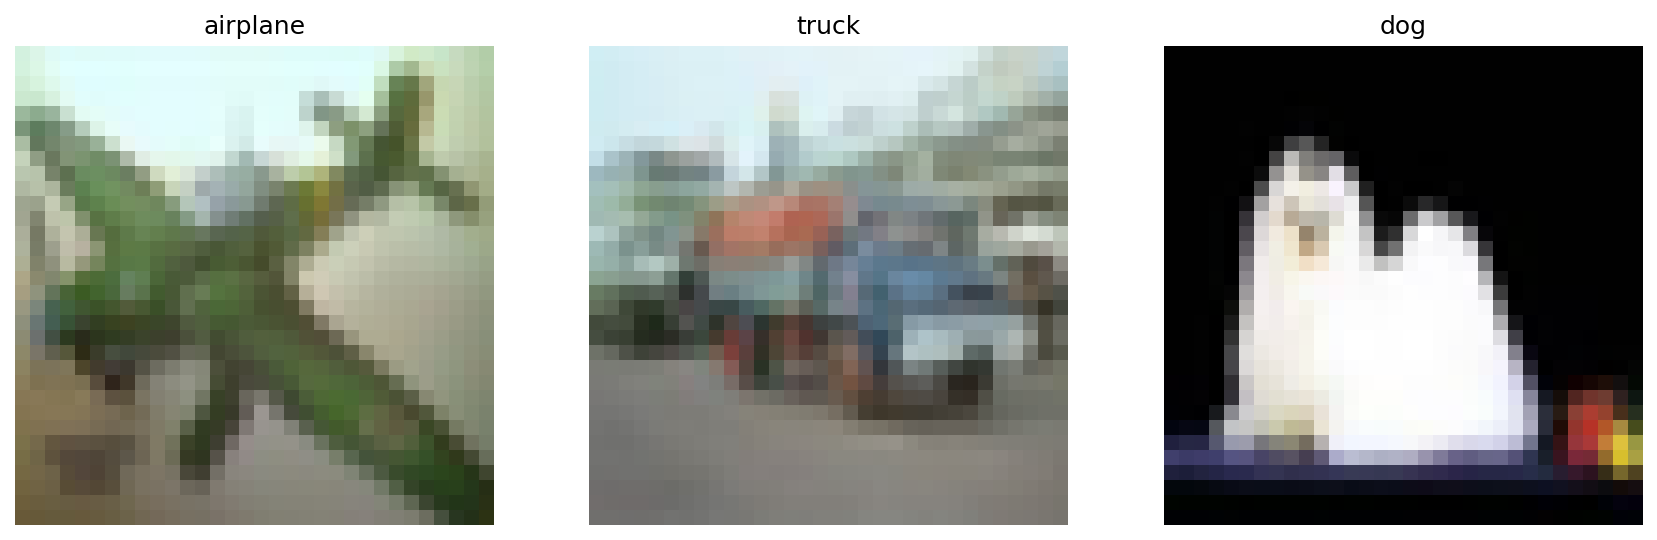

Ground truth label:  truck
Estimated label:  deer


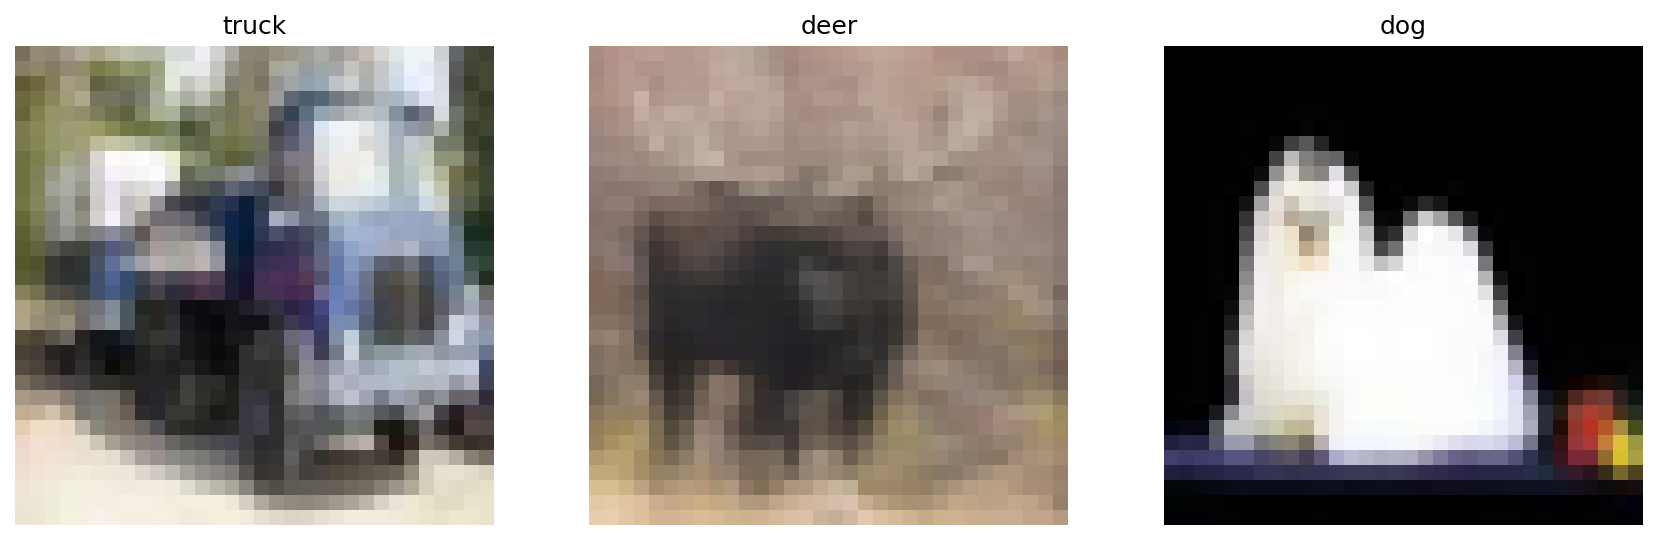

Ground truth label:  frog
Estimated label:  frog


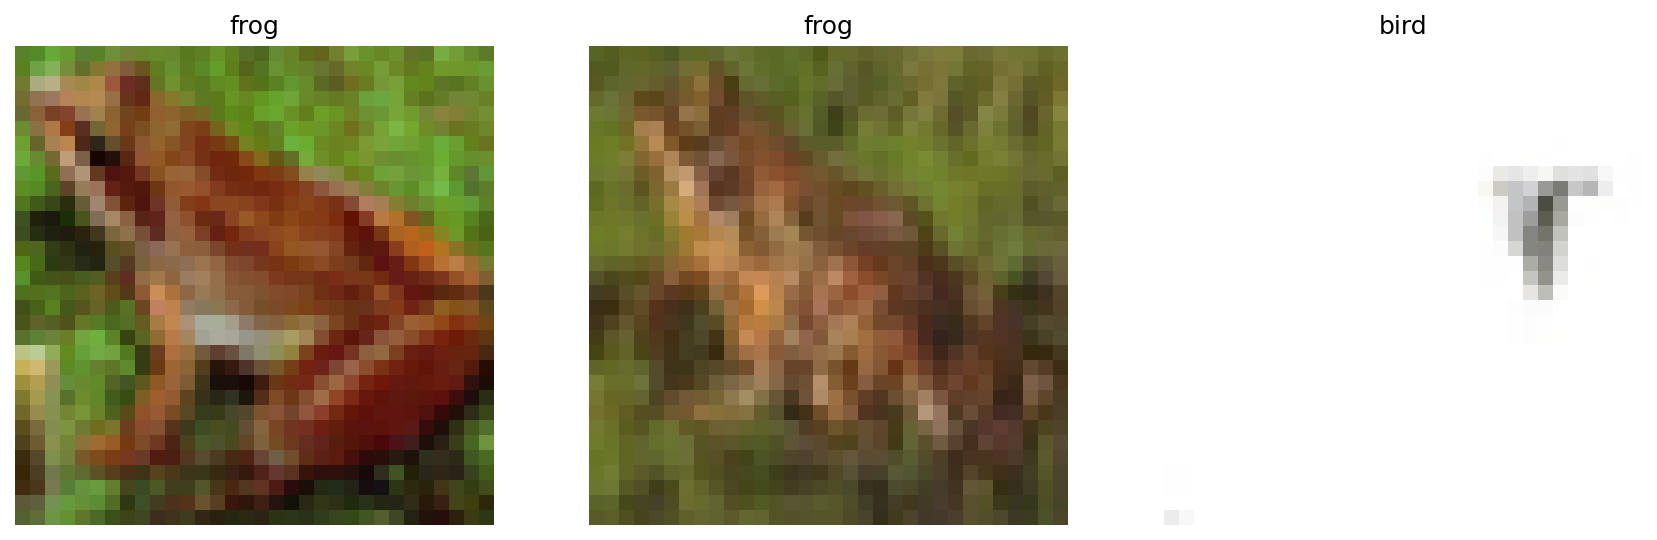

Ground truth label:  frog
Estimated label:  frog


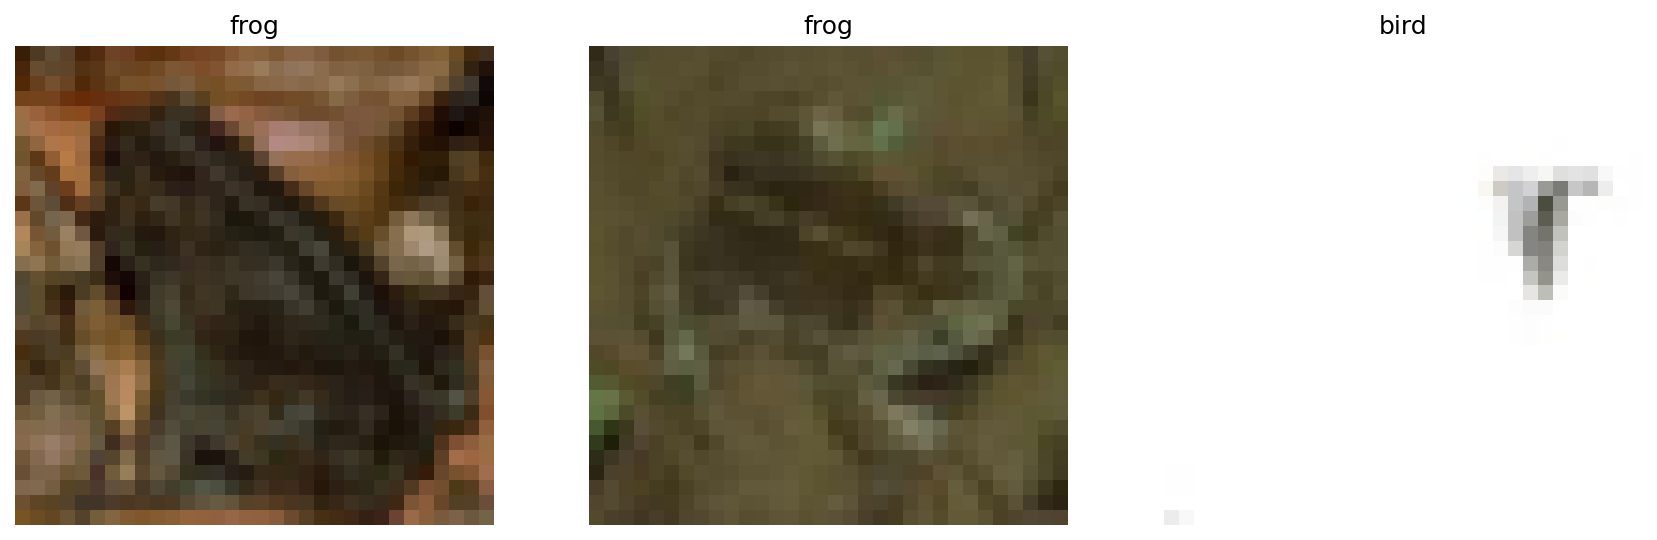

Ground truth label:  dog
Estimated label:  deer


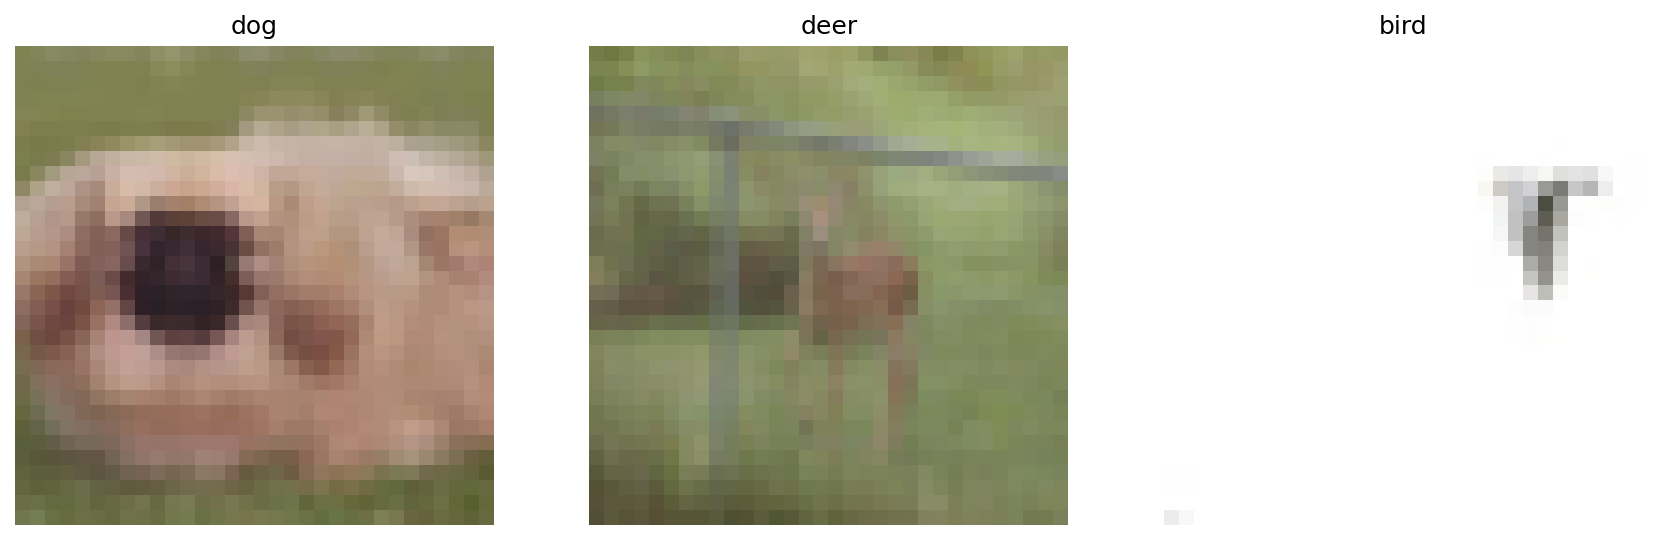

Ground truth label:  deer
Estimated label:  cat


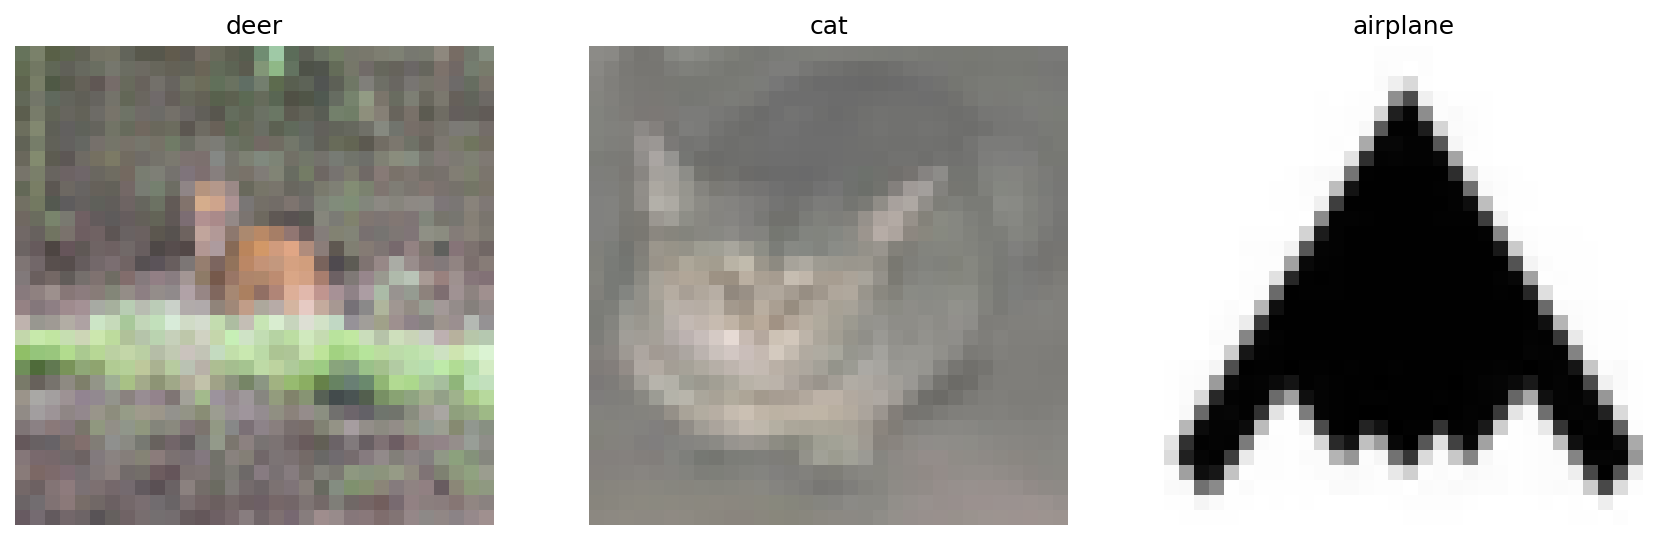

Ground truth label:  dog
Estimated label:  bird


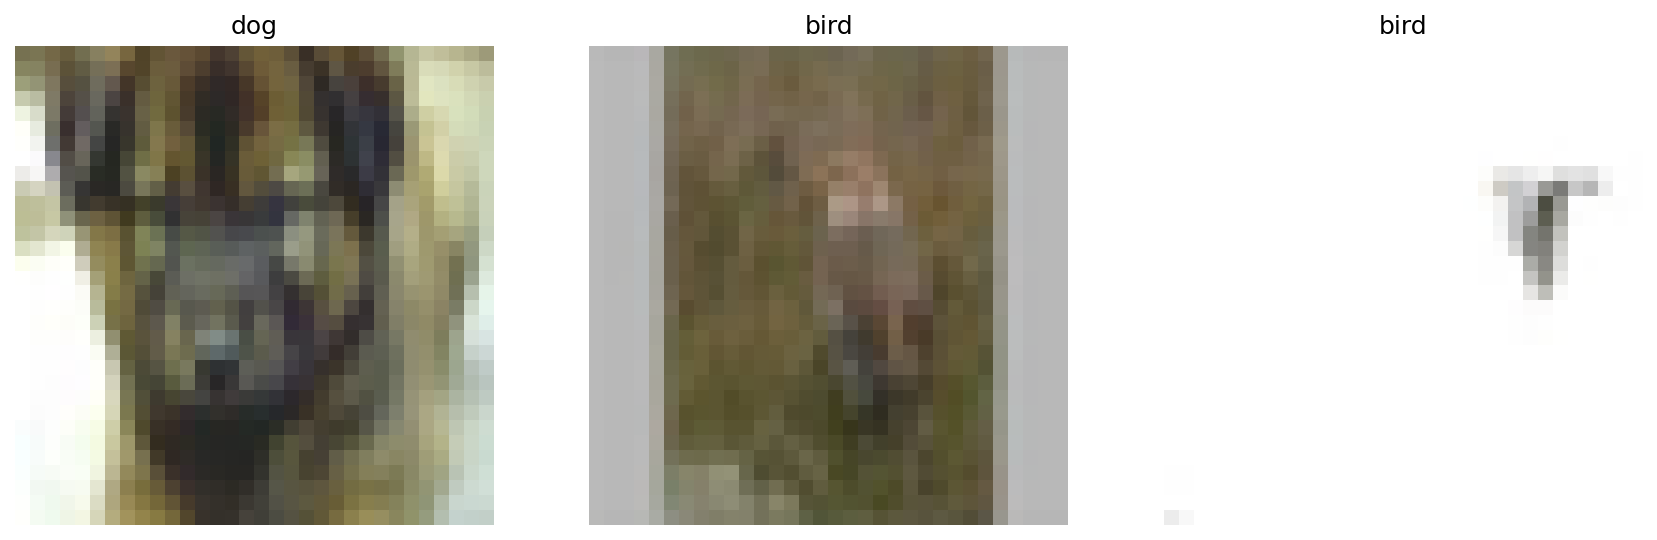

Ground truth label:  truck
Estimated label:  cat


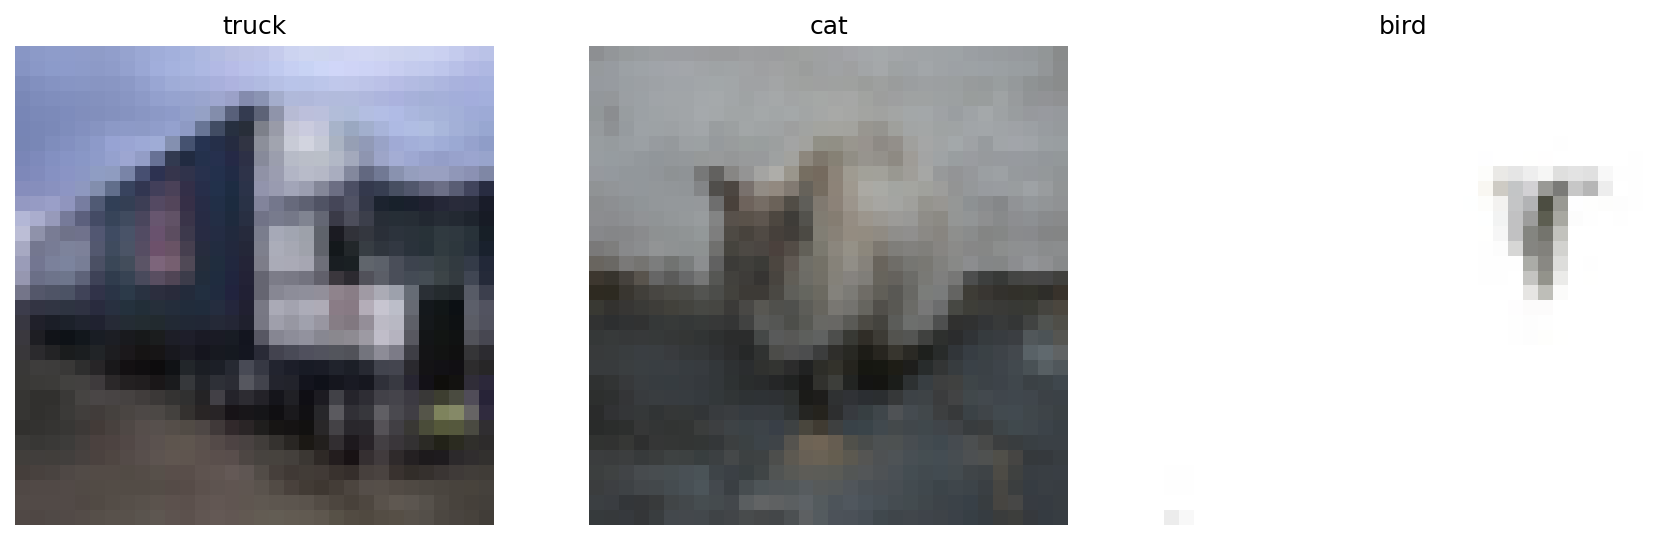

Ground truth label:  bird
Estimated label:  deer


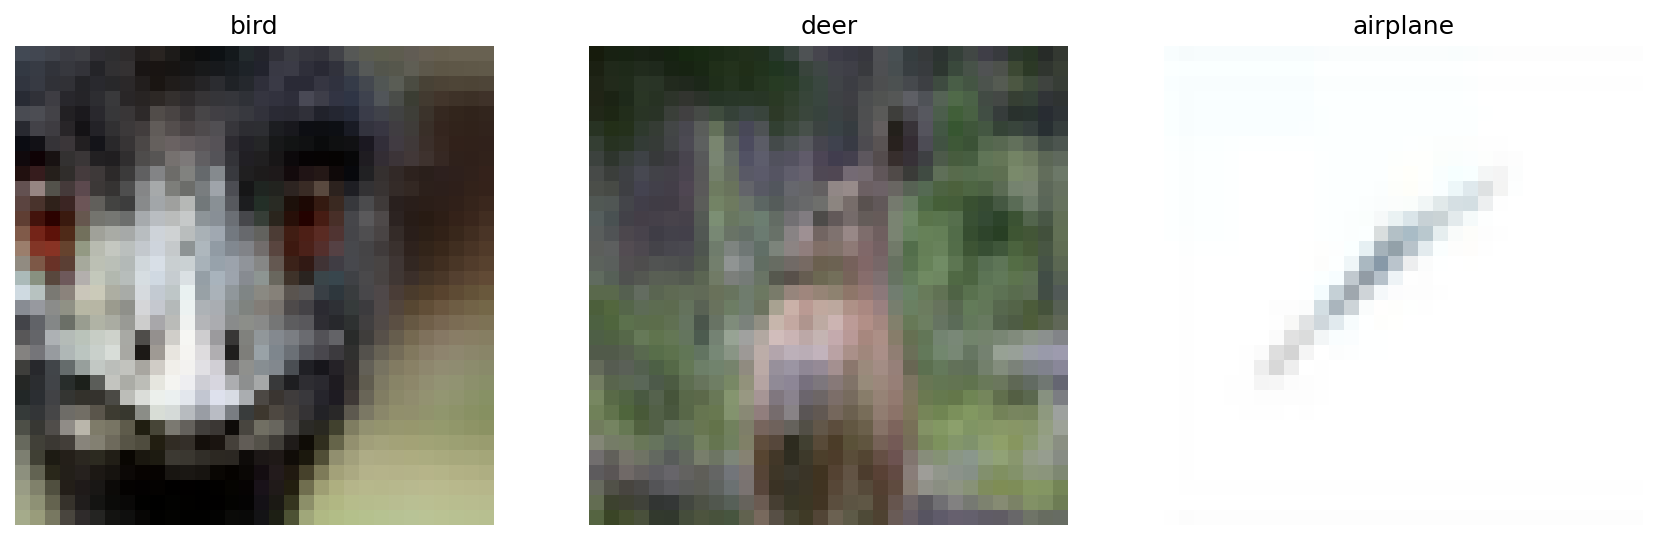

Ground truth label:  deer
Estimated label:  cat


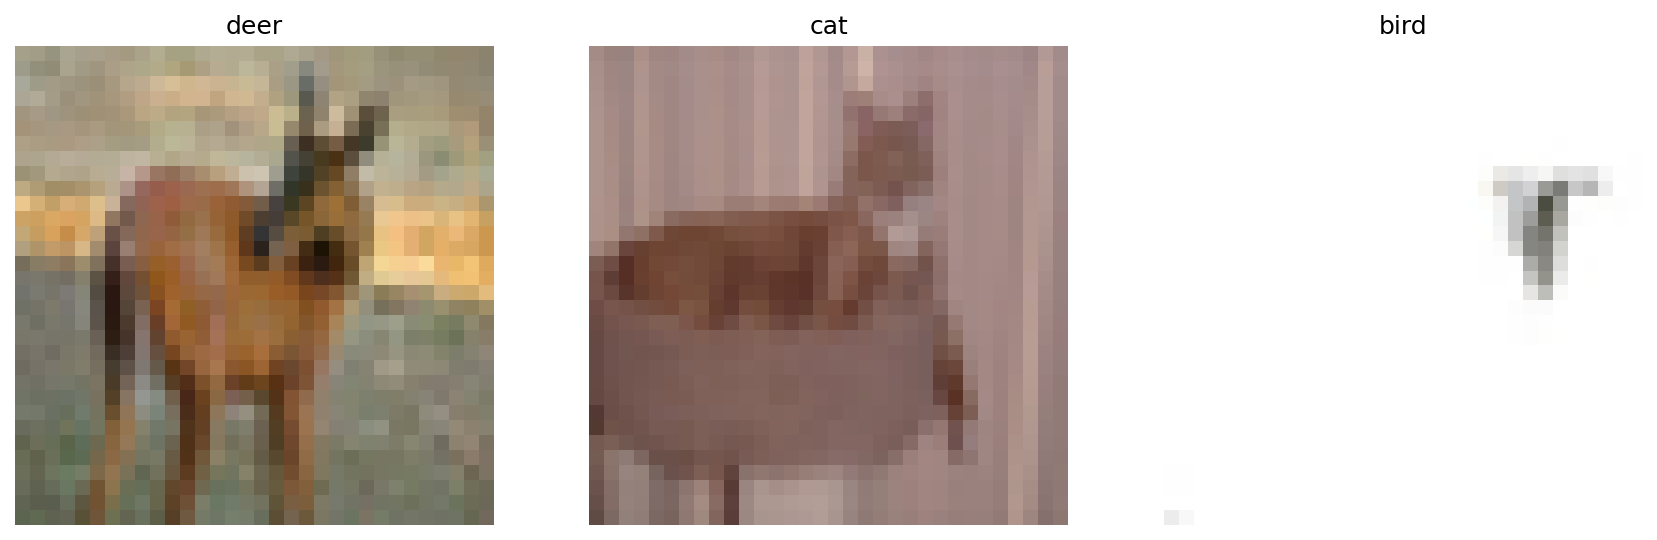

Ground truth label:  automobile
Estimated label:  ship


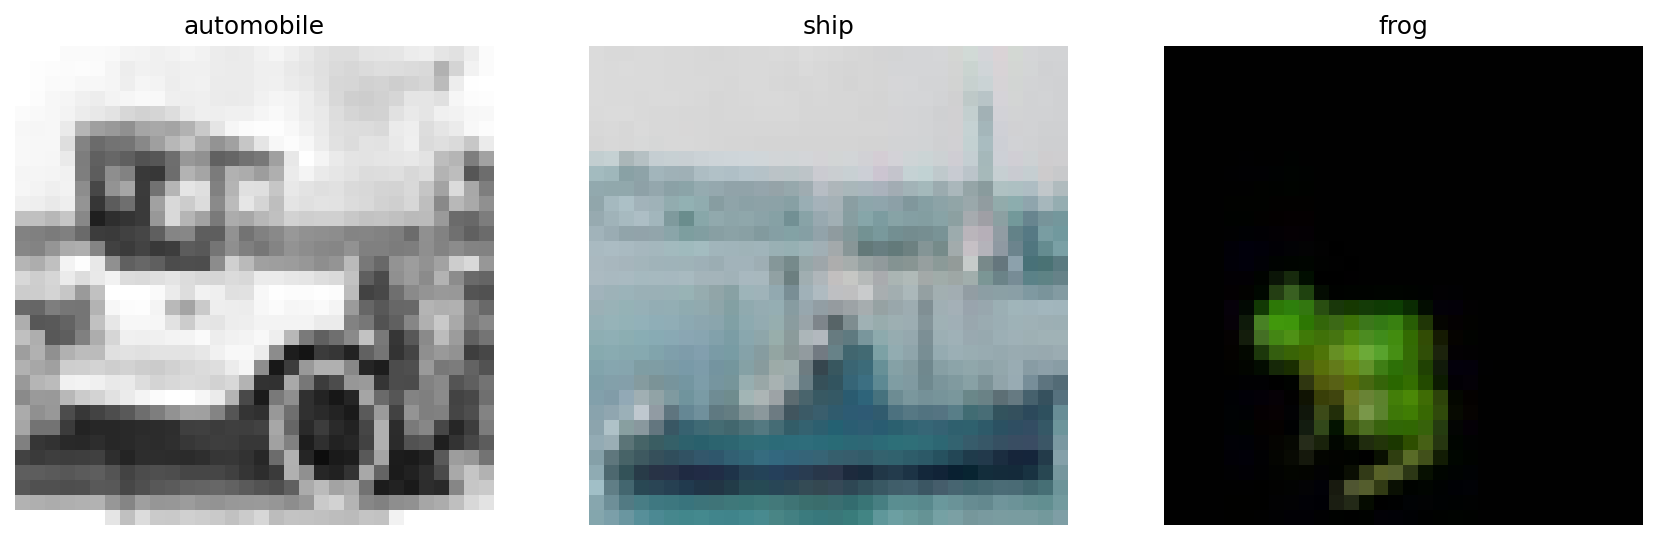

Ground truth label:  truck
Estimated label:  airplane


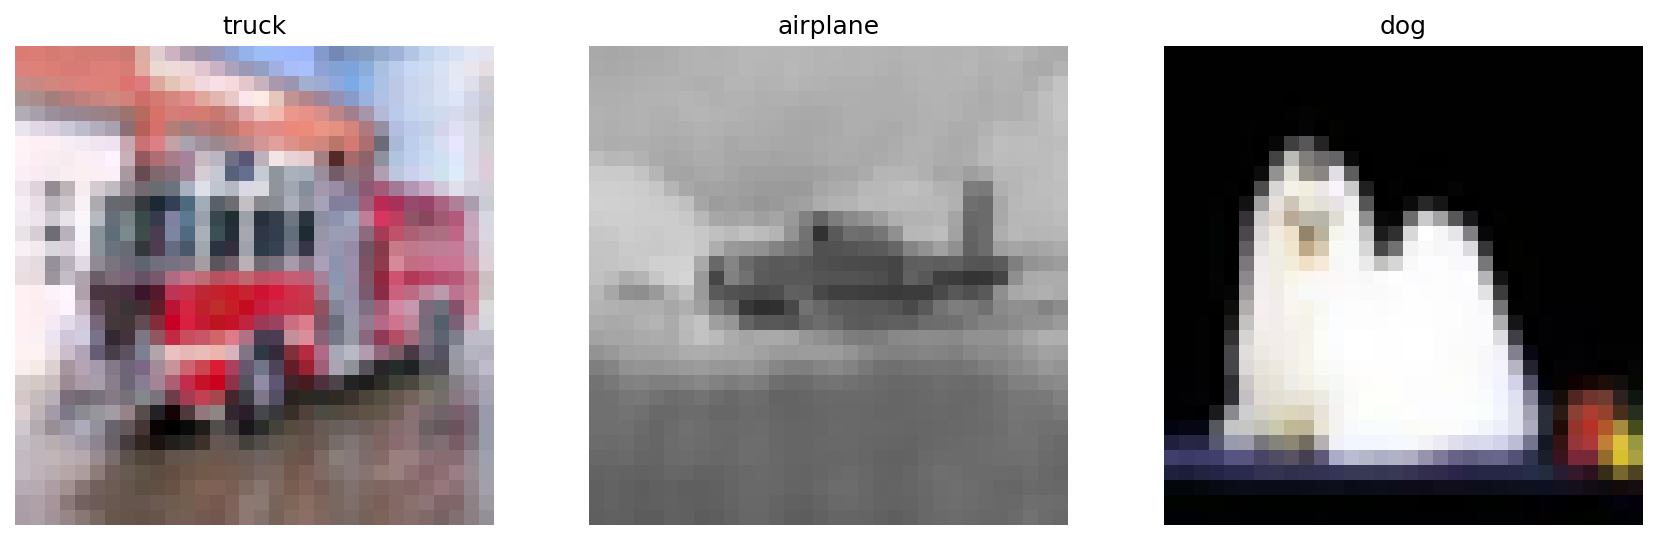

Ground truth label:  dog
Estimated label:  bird


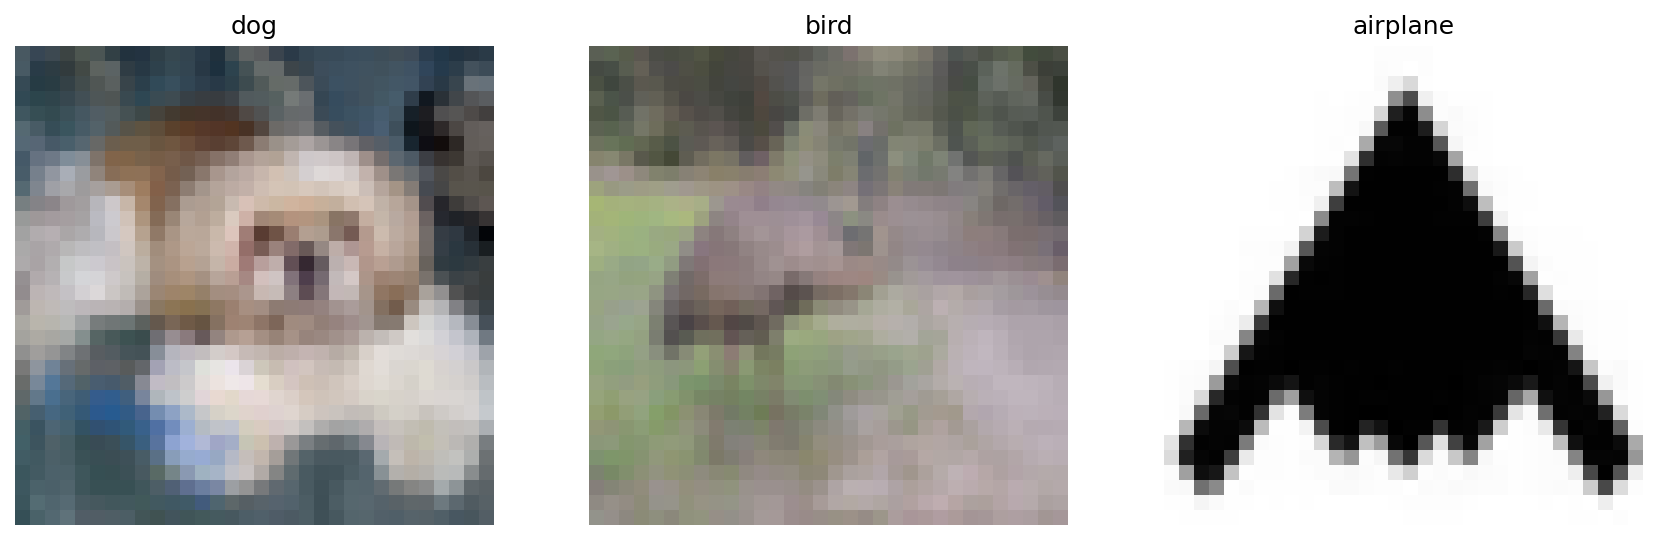

Ground truth label:  deer
Estimated label:  deer


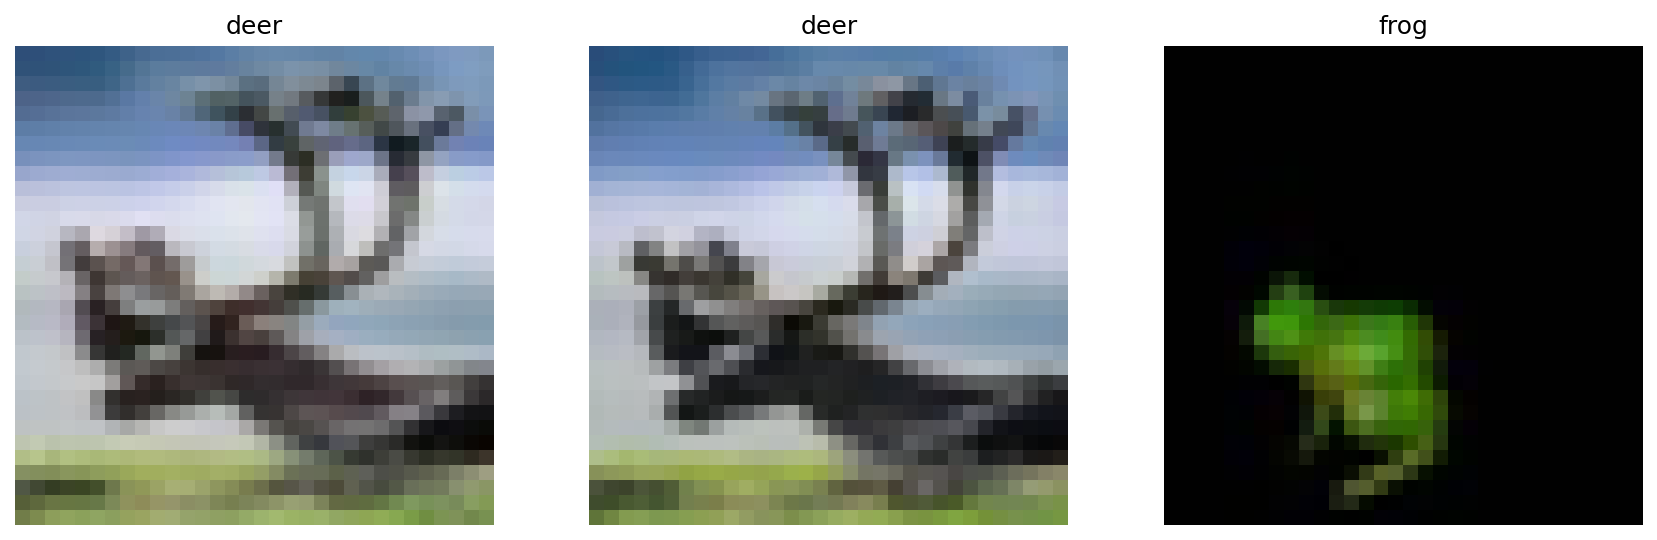

Ground truth label:  frog
Estimated label:  frog


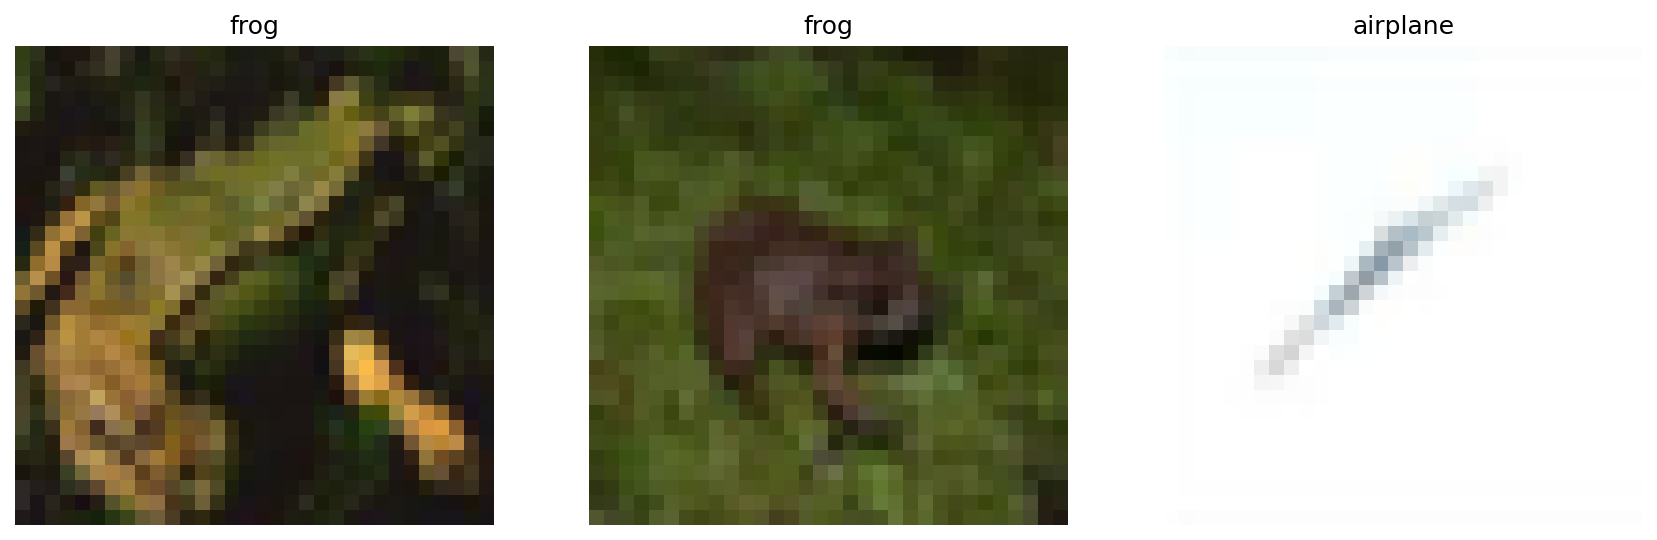

Ground truth label:  dog
Estimated label:  frog


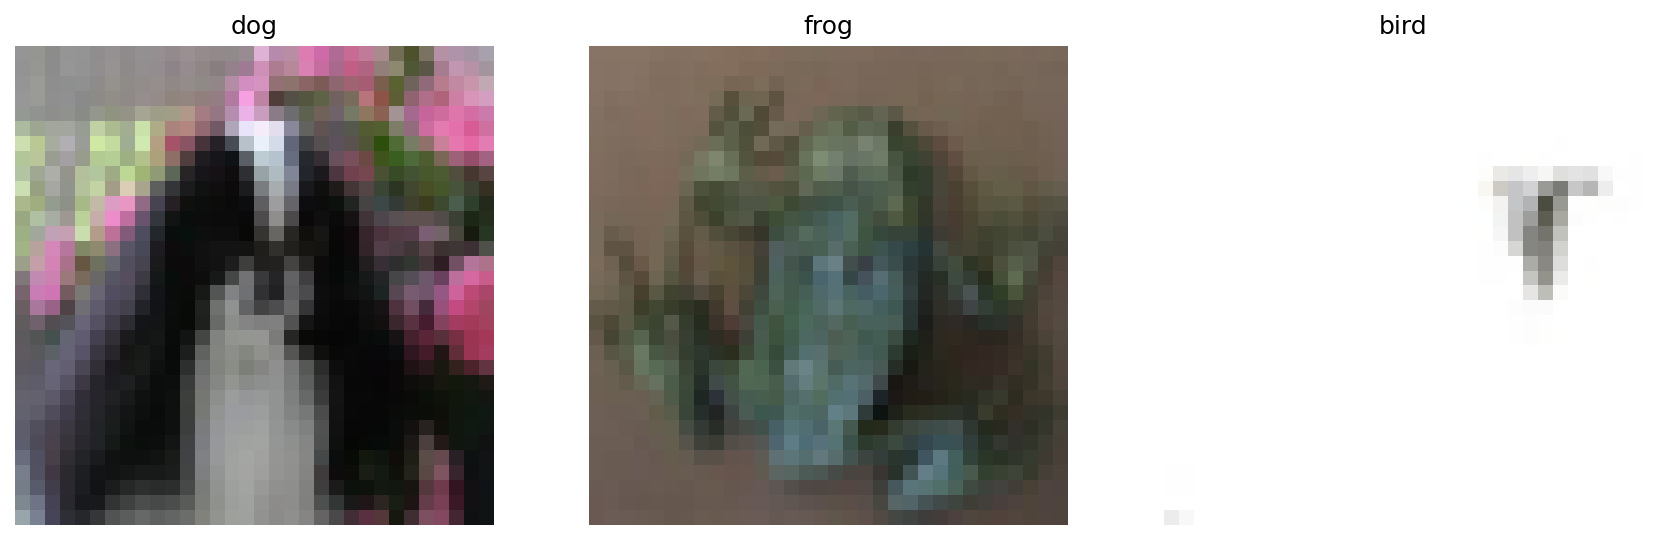

Ground truth label:  frog
Estimated label:  bird


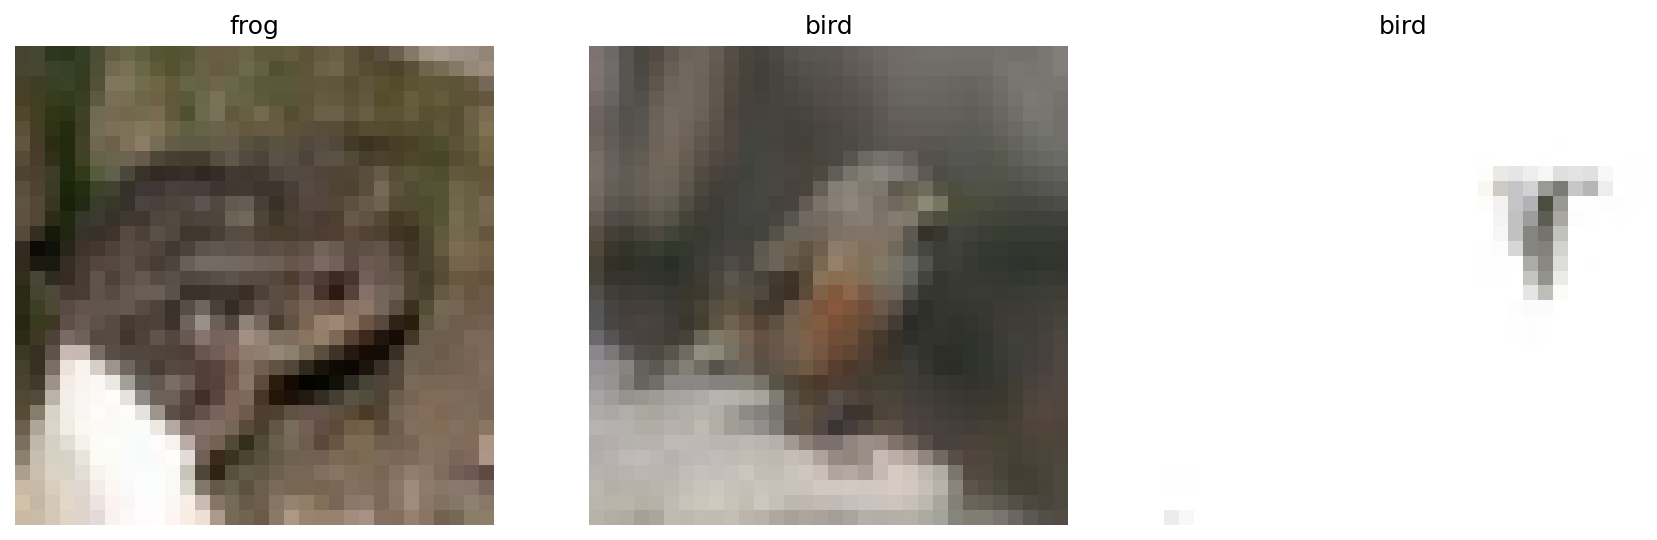

Ground truth label:  airplane
Estimated label:  airplane


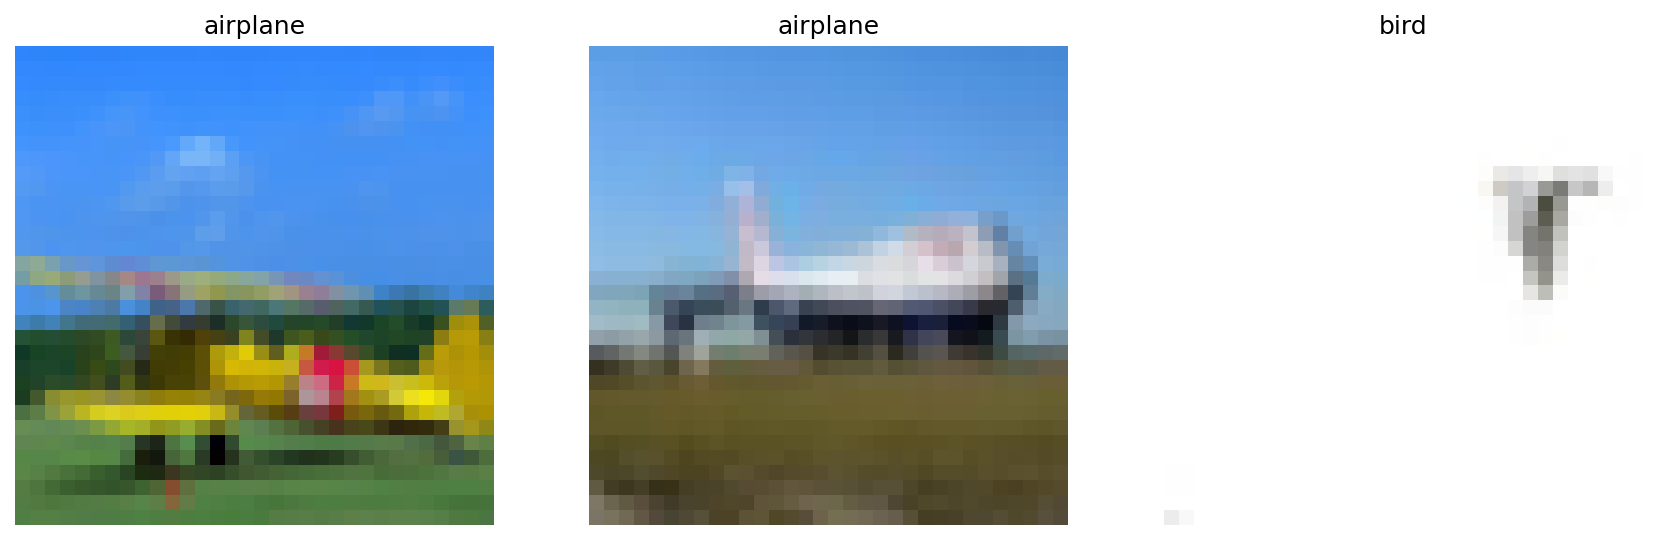

Ground truth label:  truck
Estimated label:  ship


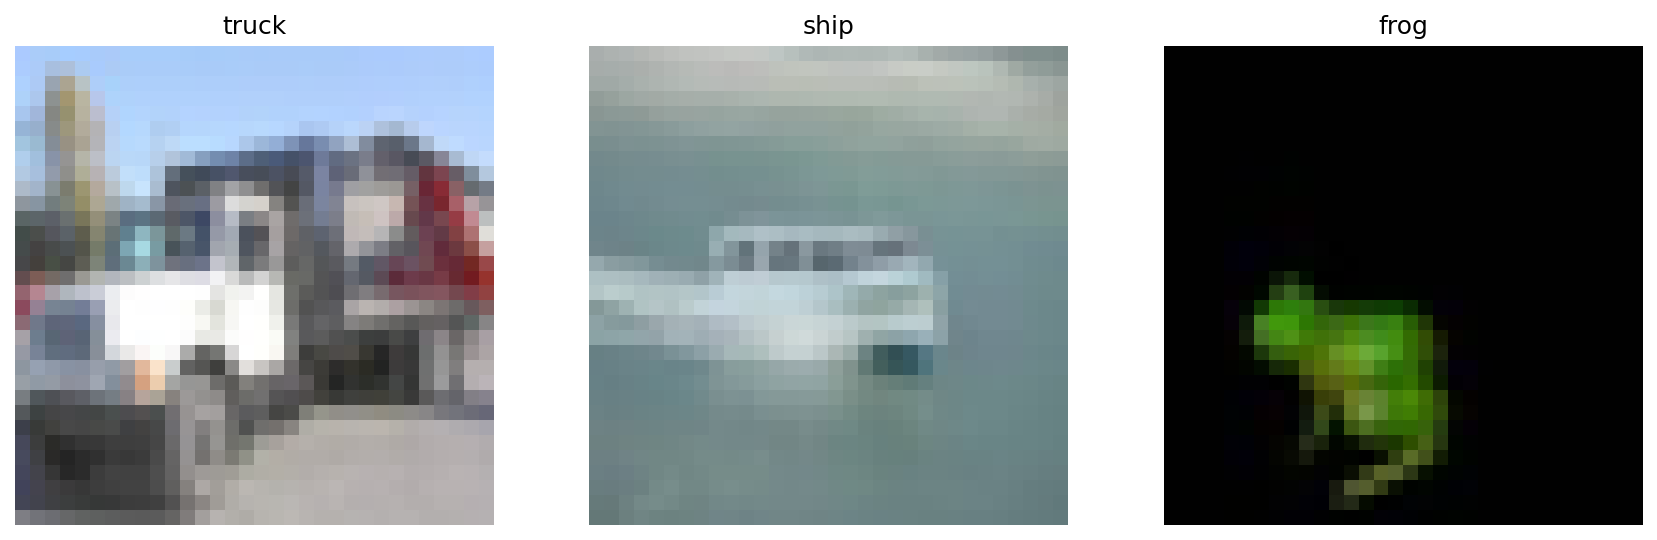

Ground truth label:  cat
Estimated label:  dog


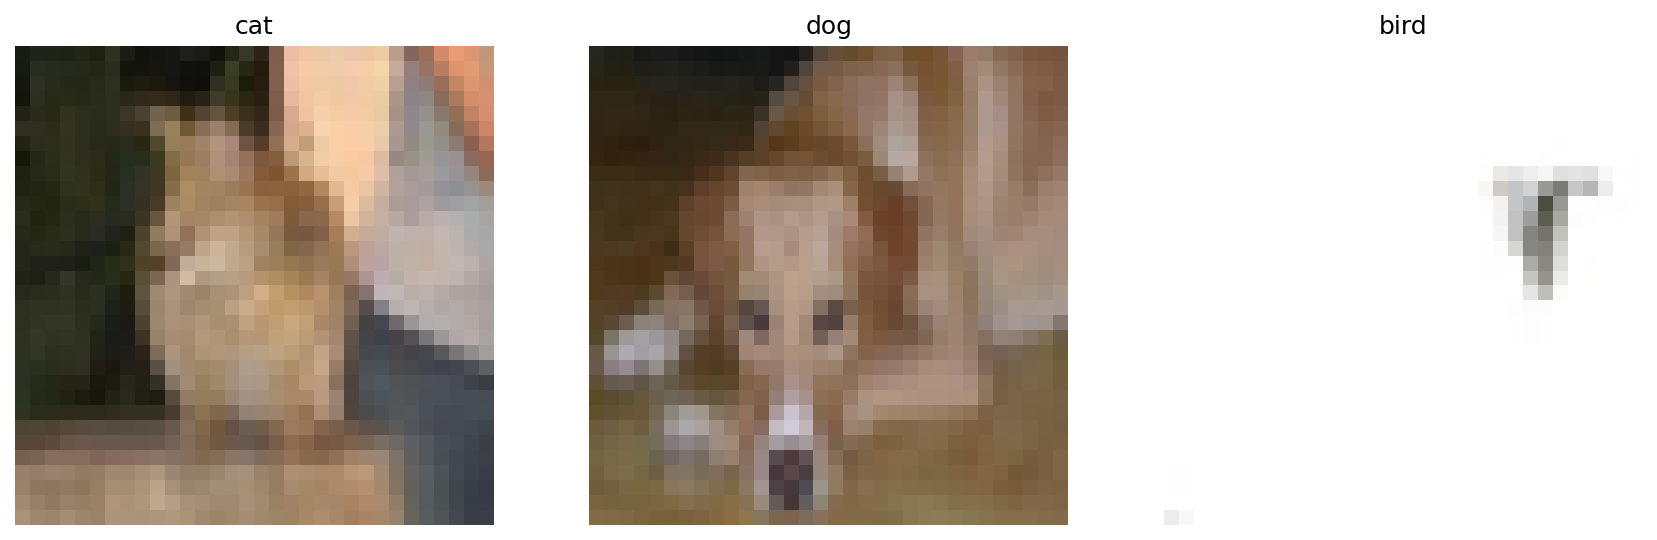

Ground truth label:  truck
Estimated label:  airplane


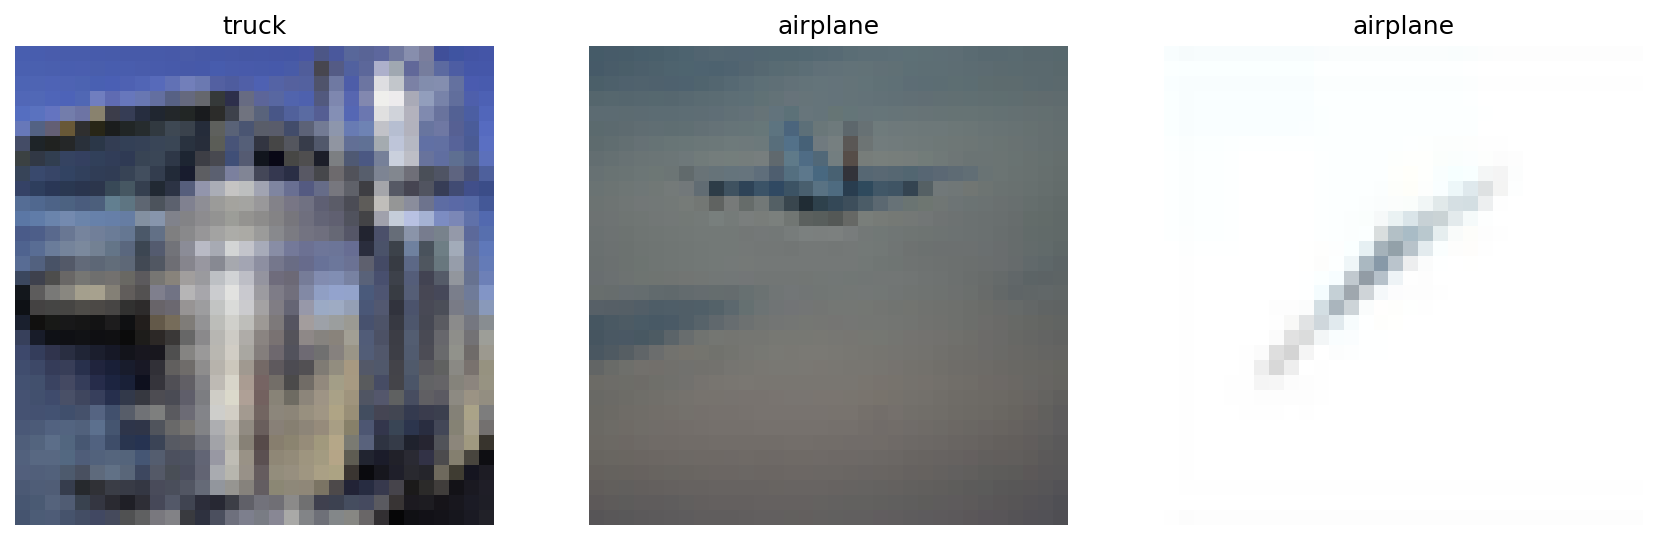

Ground truth label:  horse
Estimated label:  deer


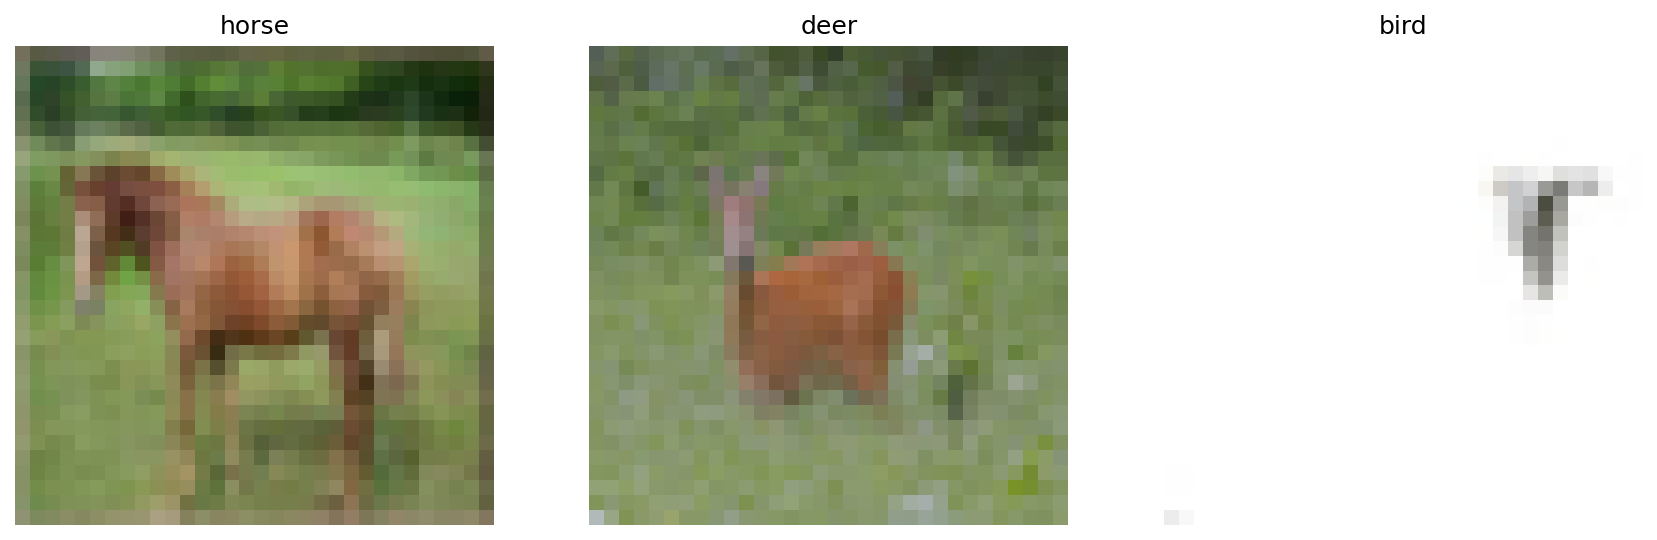

Ground truth label:  frog
Estimated label:  deer


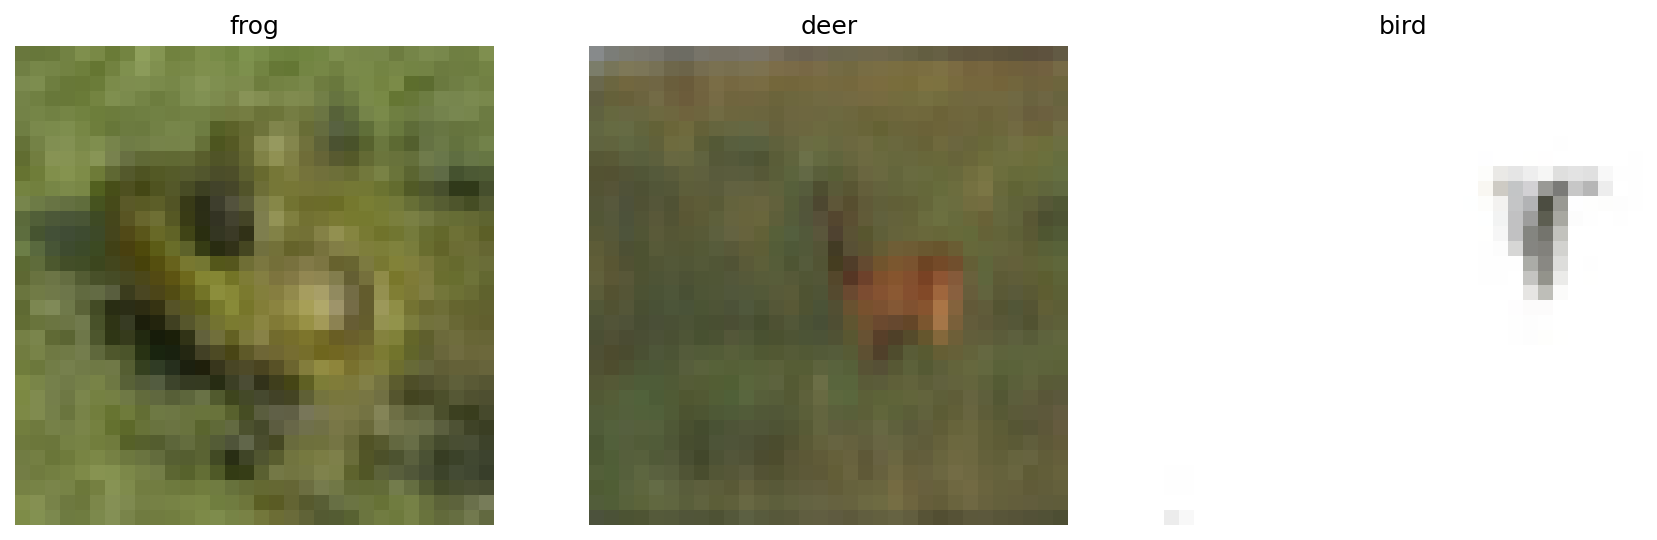

In [24]:
def distance(im1, im2):
    return np.linalg.norm((im1.astype(float) - im2.astype(float)).flatten())


y_pred = []
for testi in range(50):
    im = x_test[testi]
    l = y_test[testi]

    d = np.full(len(x_train), np.nan)
    # for each training image, we'll save its distance from the query
    for i in range(len(x_train)):
        d[i] = distance(x_train[i], im)

    i_closest = np.argmin(d)  # this is the index of the closest image
    i_farthest = np.argmax(d)  # index of the farthest image
    y_pred.append(y_train[i_closest])

    print("Ground truth label: ", labelnames[l])
    print("Estimated label: ", labelnames[y_train[i_closest]], flush=True)

    # y_true.append(l)
    # y_pred.append(y_train[i_closest])

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14, 6), dpi=150)
    # draw the test image (and label) on the first axis
    showim(x_test[testi], l=y_test[testi], ax=ax1)
    # draw the closest image (and label) on the second axis
    showim(x_train[i_closest], l=y_train[i_closest], ax=ax2)
    # draw the farthest image (and label) on the third axis
    showim(x_train[i_farthest], l=y_train[i_farthest], ax=ax3)

    plt.show()

### Evaluate how good (or bad) our baseline approach is
- in terms of classification speed
- in terms of classification accuracy

Accuracy:  0.24
[[3 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 1 0 0 0 2 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 2 1 0 0 0 0]
 [1 0 0 2 1 0 1 0 0 0]
 [0 0 2 1 2 1 1 0 0 0]
 [0 0 2 0 2 0 5 0 0 0]
 [0 0 0 1 1 0 1 0 1 0]
 [0 1 0 0 1 0 0 0 2 0]
 [2 0 0 1 2 0 0 1 2 0]]


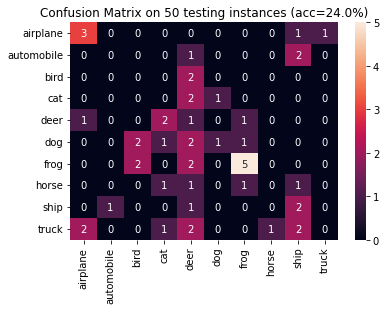

In [25]:
import sklearn.metrics

y_true = y_test[: len(y_pred)]
acc = np.mean(np.array(y_true) == np.array(y_pred))
print("Accuracy: ", acc)
cm = sklearn.metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
print(cm)

# Visualize the confusion matrix as an heatmap
import seaborn as sns

sns.heatmap(cm, annot=True, xticklabels=labelnames, yticklabels=labelnames)
plt.title(f"Confusion Matrix on {len(y_true)} testing instances (acc={acc*100}%)");

## Train a simple CNN!

In [26]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [27]:
# Create a tf.data pipeline of training images (and their labels)
train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().batch(256)
)

A simple CNN for 10-class image classification

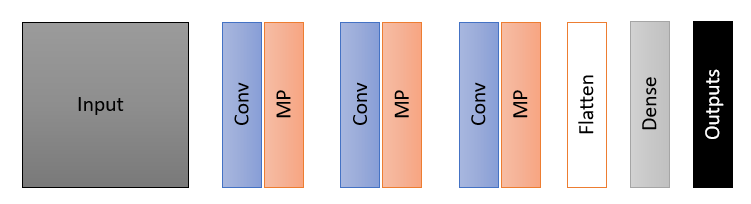

In [29]:
from keras.models import Sequential
from keras.layers import (
    Rescaling,
    Dense,
    Activation,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
)


def mkmodel(noutputs, augmentation):

    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ]
    )

    model = Sequential()
    model.add(Rescaling(1.0 / 255, input_shape=(32, 32, 3)))
    if augmentation:
        model.add(data_augmentation)
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(noutputs, activation="softmax"))

    # For a multi-class classification problem
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [31]:
model = mkmodel(10, augmentation=True)
model.fit(
    train_dataset,
    steps_per_epoch=10,
    epochs=300,
    verbose=1,
    validation_data=(x_test, y_test),
    validation_freq=[ # Do not run validation after every epoch (makes things faster)
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        10,
        12,
        15,
        20,
        30,
        40,
        50,
        70,
        100,
        150,
        200,
        250,
        300,
    ],
    callbacks=[tbcb("supervised")],
)

Epoch 1/300
10/10 [==============================] - 3s 180ms/step - loss: 2.3042 - accuracy: 0.1012 - val_loss: 2.2881 - val_accuracy: 0.1051
Epoch 2/300
10/10 [==============================] - 1s 148ms/step - loss: 2.2302 - accuracy: 0.1523 - val_loss: 2.1810 - val_accuracy: 0.2070
Epoch 3/300
10/10 [==============================] - 1s 146ms/step - loss: 2.1058 - accuracy: 0.2305 - val_loss: 2.0219 - val_accuracy: 0.2514
Epoch 4/300
10/10 [==============================] - 1s 141ms/step - loss: 2.0618 - accuracy: 0.2375 - val_loss: 2.0543 - val_accuracy: 0.2473
Epoch 5/300
10/10 [==============================] - 1s 154ms/step - loss: 2.0350 - accuracy: 0.2324 - val_loss: 1.9517 - val_accuracy: 0.2780
Epoch 6/300
10/10 [==============================] - 1s 148ms/step - loss: 2.0076 - accuracy: 0.2535 - val_loss: 1.9183 - val_accuracy: 0.3268
Epoch 7/300
10/10 [==============================] - 1s 143ms/step - loss: 1.9274 - accuracy: 0.2914 - val_loss: 1.7962 - val_accuracy: 0.3472

KeyboardInterrupt: 

Accuracy:  0.5791
[[0.595 0.133 0.032 0.005 0.01  0.004 0.011 0.023 0.078 0.109]
 [0.002 0.861 0.    0.001 0.    0.001 0.008 0.001 0.003 0.123]
 [0.077 0.056 0.328 0.037 0.079 0.066 0.186 0.078 0.027 0.066]
 [0.011 0.058 0.047 0.257 0.037 0.18  0.224 0.059 0.017 0.11 ]
 [0.025 0.029 0.049 0.038 0.344 0.031 0.269 0.168 0.006 0.041]
 [0.005 0.025 0.029 0.101 0.04  0.506 0.111 0.102 0.008 0.073]
 [0.005 0.028 0.016 0.019 0.011 0.01  0.828 0.009 0.003 0.071]
 [0.007 0.02  0.008 0.026 0.037 0.065 0.042 0.68  0.003 0.112]
 [0.083 0.177 0.015 0.01  0.002 0.004 0.012 0.003 0.606 0.088]
 [0.011 0.162 0.002 0.004 0.001 0.003 0.014 0.009 0.008 0.786]]


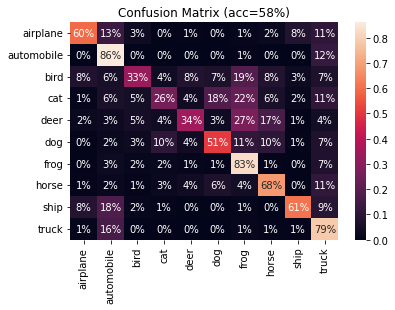

In [32]:
import sklearn
import sklearn.metrics

y_test_pred = model.predict(x_test)
acc = np.mean(y_test.flatten() == y_test_pred.argmax(axis=1))
print("Accuracy: ", acc)
cm = sklearn.metrics.confusion_matrix(
    y_true=y_test.flatten(), y_pred=y_test_pred.argmax(axis=1), normalize="true"
)
print(cm)

# Visualize the confusion matrix as an heatmap
import seaborn as sns

sns.heatmap(cm, annot=True, fmt=".0%", xticklabels=labelnames, yticklabels=labelnames)
plt.title(f"Confusion Matrix (acc={acc:.0%})");

## What if we don't have many labels?

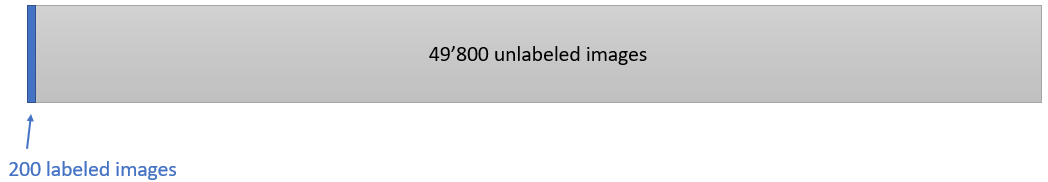

### Split the data

In [33]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [34]:
NLabeled = 200
np.random.seed(0)
perm = np.random.permutation(len(x_train))
l_ix = perm[:NLabeled]
u_ix = perm[NLabeled:]
x_train_l, y_train_l = x_train[l_ix, :, :, :], y_train[l_ix]
x_train_u, y_train_u = x_train[u_ix, :, :, :], y_train[u_ix]

### Train a baseline model that ignores unlabeled data
(does augmentation help?)

In [36]:
# Create a tf.data pipeline of images (and their labels)
train_dataset_l = (
    tf.data.Dataset.from_tensor_slices((x_train_l, y_train_l)).repeat().batch(256)
)

In [37]:
model = mkmodel(10, augmentation=False)
model.fit(
    train_dataset_l,
    steps_per_epoch=10,
    epochs=100,
    verbose=1,
    validation_data=(x_test, y_test),
    validation_freq=[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 20, 30, 40, 50, 70, 100],
    callbacks=[tbcb("task200-fromscratch-noaug")],
)

Epoch 1/100
10/10 [==============================] - 2s 169ms/step - loss: 2.2277 - accuracy: 0.1695 - val_loss: 2.1271 - val_accuracy: 0.1663
Epoch 2/100
10/10 [==============================] - 1s 143ms/step - loss: 1.9154 - accuracy: 0.3074 - val_loss: 1.9939 - val_accuracy: 0.2766
Epoch 3/100
10/10 [==============================] - 1s 141ms/step - loss: 1.5218 - accuracy: 0.4719 - val_loss: 1.9900 - val_accuracy: 0.2998
Epoch 4/100
10/10 [==============================] - 1s 143ms/step - loss: 1.1502 - accuracy: 0.6012 - val_loss: 2.1321 - val_accuracy: 0.3034
Epoch 5/100
10/10 [==============================] - 1s 140ms/step - loss: 0.8109 - accuracy: 0.7227 - val_loss: 2.3508 - val_accuracy: 0.3113
Epoch 6/100
10/10 [==============================] - 1s 148ms/step - loss: 0.4887 - accuracy: 0.8348 - val_loss: 2.7223 - val_accuracy: 0.3144
Epoch 7/100
10/10 [==============================] - 1s 147ms/step - loss: 0.2660 - accuracy: 0.9184 - val_loss: 3.3291 - val_accuracy: 0.3254

In [38]:
model = mkmodel(10, augmentation=True)
model.fit(
    train_dataset_l,
    steps_per_epoch=10,
    epochs=100,
    verbose=1,
    validation_data=(x_test, y_test),
    validation_freq=[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 20, 30, 40, 50, 70, 100],
    callbacks=[tbcb("task200-fromscratch-aug")],
)

Epoch 1/100
10/10 [==============================] - 3s 171ms/step - loss: 2.2456 - accuracy: 0.1496 - val_loss: 2.1852 - val_accuracy: 0.1684
Epoch 2/100
10/10 [==============================] - 1s 154ms/step - loss: 1.9893 - accuracy: 0.2660 - val_loss: 1.9753 - val_accuracy: 0.2920
Epoch 3/100
10/10 [==============================] - 1s 148ms/step - loss: 1.7304 - accuracy: 0.3668 - val_loss: 1.9321 - val_accuracy: 0.3089
Epoch 4/100
10/10 [==============================] - 1s 148ms/step - loss: 1.4868 - accuracy: 0.4684 - val_loss: 2.1706 - val_accuracy: 0.3042
Epoch 5/100
10/10 [==============================] - 1s 143ms/step - loss: 1.2805 - accuracy: 0.5215 - val_loss: 2.1150 - val_accuracy: 0.3386
Epoch 6/100
10/10 [==============================] - 1s 146ms/step - loss: 1.1239 - accuracy: 0.5816 - val_loss: 2.2911 - val_accuracy: 0.3352
Epoch 7/100
10/10 [==============================] - 1s 145ms/step - loss: 0.9864 - accuracy: 0.6438 - val_loss: 2.5399 - val_accuracy: 0.3351

### Implement a pretext task!
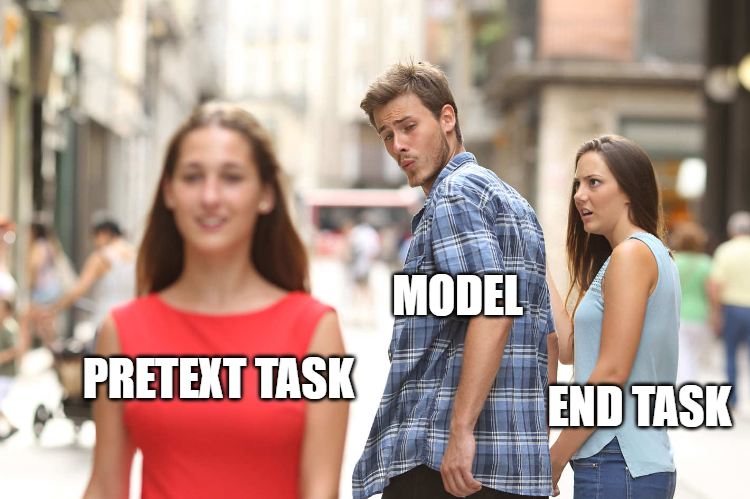

Implements https://openreview.net/pdf?id=S1v4N2l0-

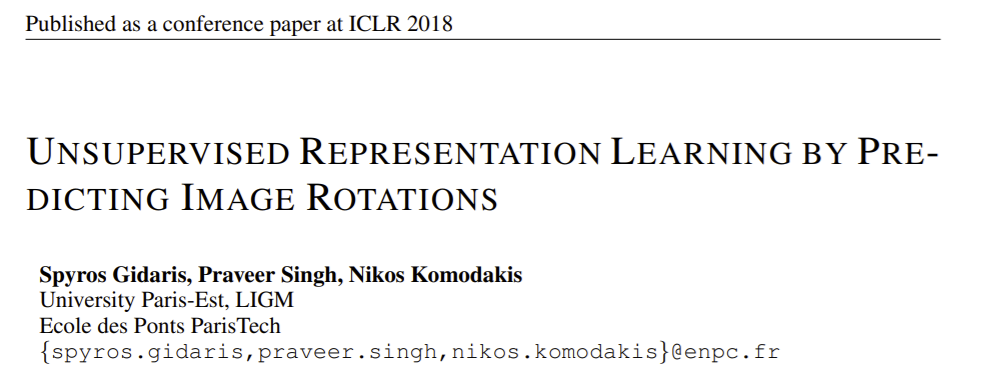

In [39]:
def myrotate(x, y):
    k = tf.random.uniform(shape=[], maxval=4, dtype=tf.int32)
    return tf.image.rot90(x, k), k


train_dataset_u = (
    tf.data.Dataset.from_tensor_slices((x_train_u, np.full(len(y_train_u), np.nan)))
    .repeat()
    .map(myrotate)
    .batch(256)
)
test_dataset_u = (
    tf.data.Dataset.from_tensor_slices((x_test, np.full(len(y_test), np.nan)))
    .map(myrotate)
    .batch(256)
)

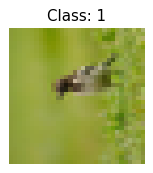

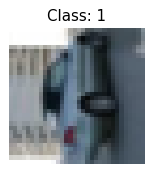

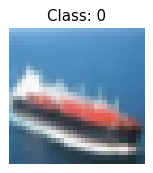

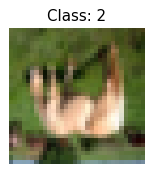

In [40]:
batch = next(iter(train_dataset_u))
for x, y in list(zip(batch[0], batch[1]))[:4]:
    fig, ax = plt.subplots(figsize=(2, 2), dpi=90)
    showim(x, ax=ax)
    ax.set_title(f"Class: {y}")
    plt.show()

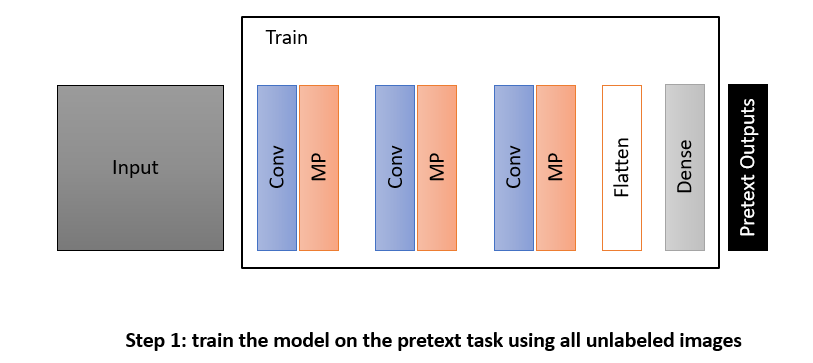

In [41]:
model = mkmodel(4, augmentation=True)

In [42]:
reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=10
)
model.fit(
    train_dataset_u,
    steps_per_epoch=200,
    epochs=1000,
    validation_data=test_dataset_u,
    callbacks=[tbcb("pretext"), reducelr],
)

Epoch 1/1000
200/200 [==============================] - 10s 43ms/step - loss: 1.2853 - accuracy: 0.3622 - val_loss: 1.1452 - val_accuracy: 0.5049 - lr: 0.0010
Epoch 2/1000
200/200 [==============================] - 9s 43ms/step - loss: 1.1913 - accuracy: 0.4269 - val_loss: 1.0994 - val_accuracy: 0.4282 - lr: 0.0010
Epoch 3/1000
200/200 [==============================] - 9s 44ms/step - loss: 1.1537 - accuracy: 0.4488 - val_loss: 1.0683 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 4/1000
200/200 [==============================] - 9s 44ms/step - loss: 1.1321 - accuracy: 0.4581 - val_loss: 1.0439 - val_accuracy: 0.4738 - lr: 0.0010
Epoch 5/1000
200/200 [==============================] - 9s 44ms/step - loss: 1.1083 - accuracy: 0.4705 - val_loss: 1.0011 - val_accuracy: 0.5691 - lr: 0.0010
Epoch 6/1000
200/200 [==============================] - 9s 44ms/step - loss: 1.0949 - accuracy: 0.4814 - val_loss: 1.0048 - val_accuracy: 0.5149 - lr: 0.0010
Epoch 7/1000
200/200 [=============================

KeyboardInterrupt: 

In [ ]:
model.save("orientations.kerasmodel")

## Take the model trained for the pretext task, and use it to train the end task

In [49]:
model = keras.models.load_model("orientations.kerasmodel")

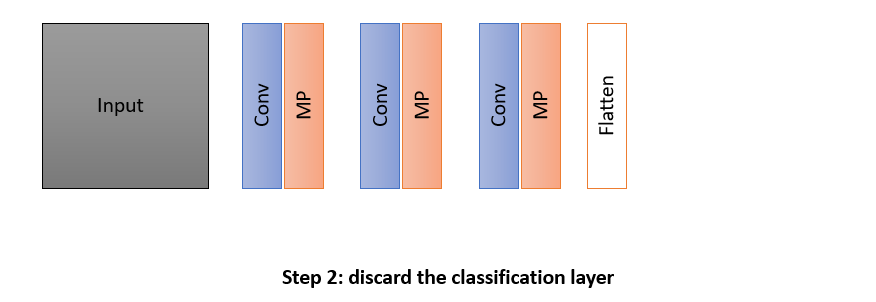

In [50]:
model.pop()
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 sequential_22 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 conv2d_44 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_45 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 15, 15, 32)        0         
                                                     

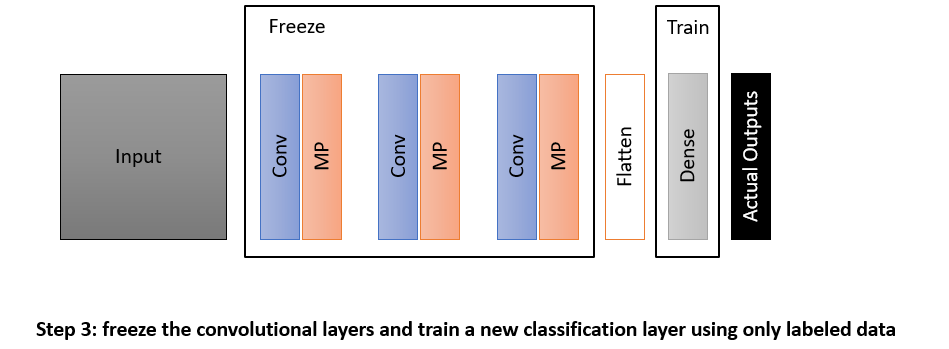

In [51]:
model.add(keras.layers.Dense(10, activation="softmax"))
# model.summary()

In [52]:
for l in model.layers[:-1]:
    l.trainable = False

In [53]:
for l in model.layers:
    print(l.name, l.trainable)

rescaling_11 False
sequential_22 False
conv2d_44 False
conv2d_45 False
max_pooling2d_22 False
dropout_33 False
conv2d_46 False
conv2d_47 False
max_pooling2d_23 False
dropout_34 False
flatten_11 False
dense_22 False
dropout_35 False
dense_11 True


In [54]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [55]:
model.fit(
    train_dataset_l,
    steps_per_epoch=10,
    epochs=100,
    validation_data=(x_test, y_test),
    validation_freq=[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 20, 30, 40, 50, 70, 100],
    callbacks=[tbcb("task200-pretrained-frozen")],
)

Epoch 1/100
10/10 [==============================] - 2s 164ms/step - loss: 2.4805 - accuracy: 0.1105 - val_loss: 2.2920 - val_accuracy: 0.1176
Epoch 2/100
10/10 [==============================] - 1s 124ms/step - loss: 2.2482 - accuracy: 0.1711 - val_loss: 2.1078 - val_accuracy: 0.1901
Epoch 3/100
10/10 [==============================] - 1s 129ms/step - loss: 2.1190 - accuracy: 0.2070 - val_loss: 2.0111 - val_accuracy: 0.2299
Epoch 4/100
10/10 [==============================] - 1s 125ms/step - loss: 1.9930 - accuracy: 0.2750 - val_loss: 1.9180 - val_accuracy: 0.2835
Epoch 5/100
10/10 [==============================] - 1s 138ms/step - loss: 1.9010 - accuracy: 0.3086 - val_loss: 1.8422 - val_accuracy: 0.3300
Epoch 6/100
10/10 [==============================] - 1s 125ms/step - loss: 1.8080 - accuracy: 0.3438 - val_loss: 1.7895 - val_accuracy: 0.3620
Epoch 7/100
10/10 [==============================] - 1s 131ms/step - loss: 1.7463 - accuracy: 0.3730 - val_loss: 1.7506 - val_accuracy: 0.3860

## What if we allow the model to also tweak the feature extraction layers?

In [ ]:
model.trainable = True
for l in model.layers:
    print(l.name, l.trainable)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
model.fit(
    train_dataset_l,
    steps_per_epoch=10,
    epochs=100,
    validation_data=(x_test, y_test),
    validation_freq=[1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 20, 30, 40, 50, 70, 100],
    callbacks=[tbcb("task-pretrained-finetuning")],
)

In [ ]:
np.mean(
    tf.keras.metrics.sparse_top_k_categorical_accuracy(
        y_test, model.predict(x_test), k=3
    ).numpy()
)